<a href="https://colab.research.google.com/github/HBaldwin3/CaseStudy_FSH_LaoPDR/blob/main/Manuscript_Graphs_4_25_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up workspace

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal  
import sklearn
from sklearn.metrics import mean_squared_error 
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats
from scipy.stats import *
import math
import statistics
import matplotlib as mpl

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [ ]:
cd /content/notebooks/validation_resamp6ha/

/content/mnt/My Drive/Colab Notebooks/validation_resamp6ha


#Bring in & clean datasets

In [ ]:
#xnew_lid_bs is the testing LIDAR for backscatter comparison
#ynew_lid_bs is the corresponding Backscatter

lidar_testing = "LiDAR_testing.tif"
lidar = gdal.Open(lidar_testing)
xlidar = lidar.ReadAsArray()

backscatter = "test_EstimatedHeight_resamp_6ha_curvefit_v17.tif"
bs_FSH = gdal.Open(backscatter)
bs = bs_FSH.ReadAsArray()

print(bs.shape)
print(xlidar.shape)

x_rav = np.array(xlidar).ravel()

y_bs = np.array(bs).ravel()

x_nan = np.where(x_rav<0, np.NaN, x_rav)

y_nan = np.where(y_bs<0, np.NaN, y_bs)

bad_bs = ~np.logical_or(np.isnan(x_nan), np.isnan(y_nan))

xnew_lid_bs = np.compress(bad_bs, x_nan)
ynew_lid_bs = np.compress(bad_bs, y_nan)

#xnew_lid_in is the testing LiDAR for the InSAR compariosn
#ynew_lid_in is the corresponding InSAR
insar_2009 = "insar_2009_testing.tif"
insar = gdal.Open(insar_2009)
ylidar = insar.ReadAsArray()

y_rav = np.array(ylidar).ravel()
print("y_insar", y_rav.shape) 

y_nan = np.where(y_rav>60000, np.NaN, y_rav)

bad_in = ~np.logical_or(np.isnan(x_nan), np.isnan(y_nan))

xnew_lid_in = np.compress(bad_in, x_nan)
ynew_lid_in = np.compress(bad_in, y_nan)

#xnew_lid_fus is the testing LiDAR for the fusion comparison
#ynew_lid_fus is corresponding Fusion
fusion = "fusion_v3_testing.tif"
f_FSH = gdal.Open(fusion)
fus = f_FSH.ReadAsArray()
y_fus = np.array(fus).ravel()
y_nan = np.where(y_fus<0, np.NaN, y_fus)

bad_fus = ~np.logical_or(np.isnan(x_nan), np.isnan(y_nan))

xnew_lid_fus = np.compress(bad_fus, x_nan)
ynew_lid_fus = np.compress(bad_fus, y_nan)

#xgedi_b is the GEDI for the backscatter comparison
#ygedi_b is the corresponding backscatter
data = pd.read_excel("pair_GEDI.xlsx")

data_nan = np.where(data<0, np.nan, data)
data_df = pd.DataFrame(data_nan, columns = ['GEDI', 'InSAR', 'Backscatter', 'Fusion'])

data_select = pd.DataFrame(data_df[['Backscatter', 'GEDI']])

data_dropna = data_select.dropna()

xgedi_b = data_dropna["GEDI"]
ygedi_b = data_dropna["Backscatter"]

#xgedi_i is the GEDI for the insar compariosn
#ygedi_i is the corresponding insar

data_select = pd.DataFrame(data_df[['InSAR', 'GEDI']])

data_dropna = data_select.dropna()

xgedi_i = data_dropna["GEDI"]
ygedi_i = data_dropna["InSAR"]

#xgedi_f is the GEDI for the fusion comparison
#ygedi_f is the corresponding fusion
data_select = pd.DataFrame(data_df[['Fusion', 'GEDI']])

data_dropna = data_select.dropna()

xgedi_f = data_dropna["GEDI"]
ygedi_f = data_dropna["Fusion"]

#xglad_b is the GLAD for the backscatter comparison
#yglad_b is the corresponding backscatter
bs_fus = "backscatter_v17_extract_fus.tif"
bs_o = gdal.Open(bs_fus)
bs_array = bs_o.ReadAsArray()

bs_rav = np.array(bs_array).ravel()
bs_nan = np.where(bs_rav<0, np.NaN, bs_rav)

GLAD = "GLAD_2019_extractv2.tif"
glad_o = gdal.Open(GLAD)
glad_array = glad_o.ReadAsArray()

x_rav = np.array(glad_array).ravel()
x_nan = np.where(x_rav<0, np.NaN, x_rav)

bad_glad_b = ~np.logical_or(np.isnan(x_nan), np.isnan(bs_nan))

xglad_b = np.compress(bad_glad_b, x_nan)
yglad_b = np.compress(bad_glad_b, bs_nan)

#xglad_i is the GLAD for the insar comparison
#yglad_i is the corresponding insar

insar_forglad = "insar_2009_6ha_extractv2.tif"
insar_o = gdal.Open(insar_forglad)
insar_array = insar_o.ReadAsArray()

#add ravel for insar
y_insar = np.array(insar_array).ravel()

#add nan for insar
insar_nan = np.where(y_insar<0, np.nan, y_insar)

bad_glad_i = ~np.logical_or(np.isnan(x_nan), np.isnan(insar_nan))

xglad_i = np.compress(bad_glad_i, x_nan)
yglad_i = np.compress(bad_glad_i, insar_nan) #this was wrong in previous iterations
#xglad_f is the GLAD for the fusion comparison
#yglad_f is the corresponding fusion
fusion = "Fusion_v3.tif"
f_FSH = gdal.Open(fusion)
fus = f_FSH.ReadAsArray()

y_fus = np.array(fus).ravel()

pred_nan = np.where(y_fus<0, np.NaN, y_fus)

bad_glad_f = ~np.logical_or(np.isnan(x_nan), np.isnan(pred_nan))

xglad_f = np.compress(bad_glad_f, x_nan)
yglad_f = np.compress(bad_glad_f, pred_nan)

(86, 139)
(86, 139)
y_insar (11954,)


#Big comparison graph (& calculate metrics?)

need to : set y axis bc data is getting cut off, deal w nodata, add colorbar, whats the best bin, add n = to each subplot

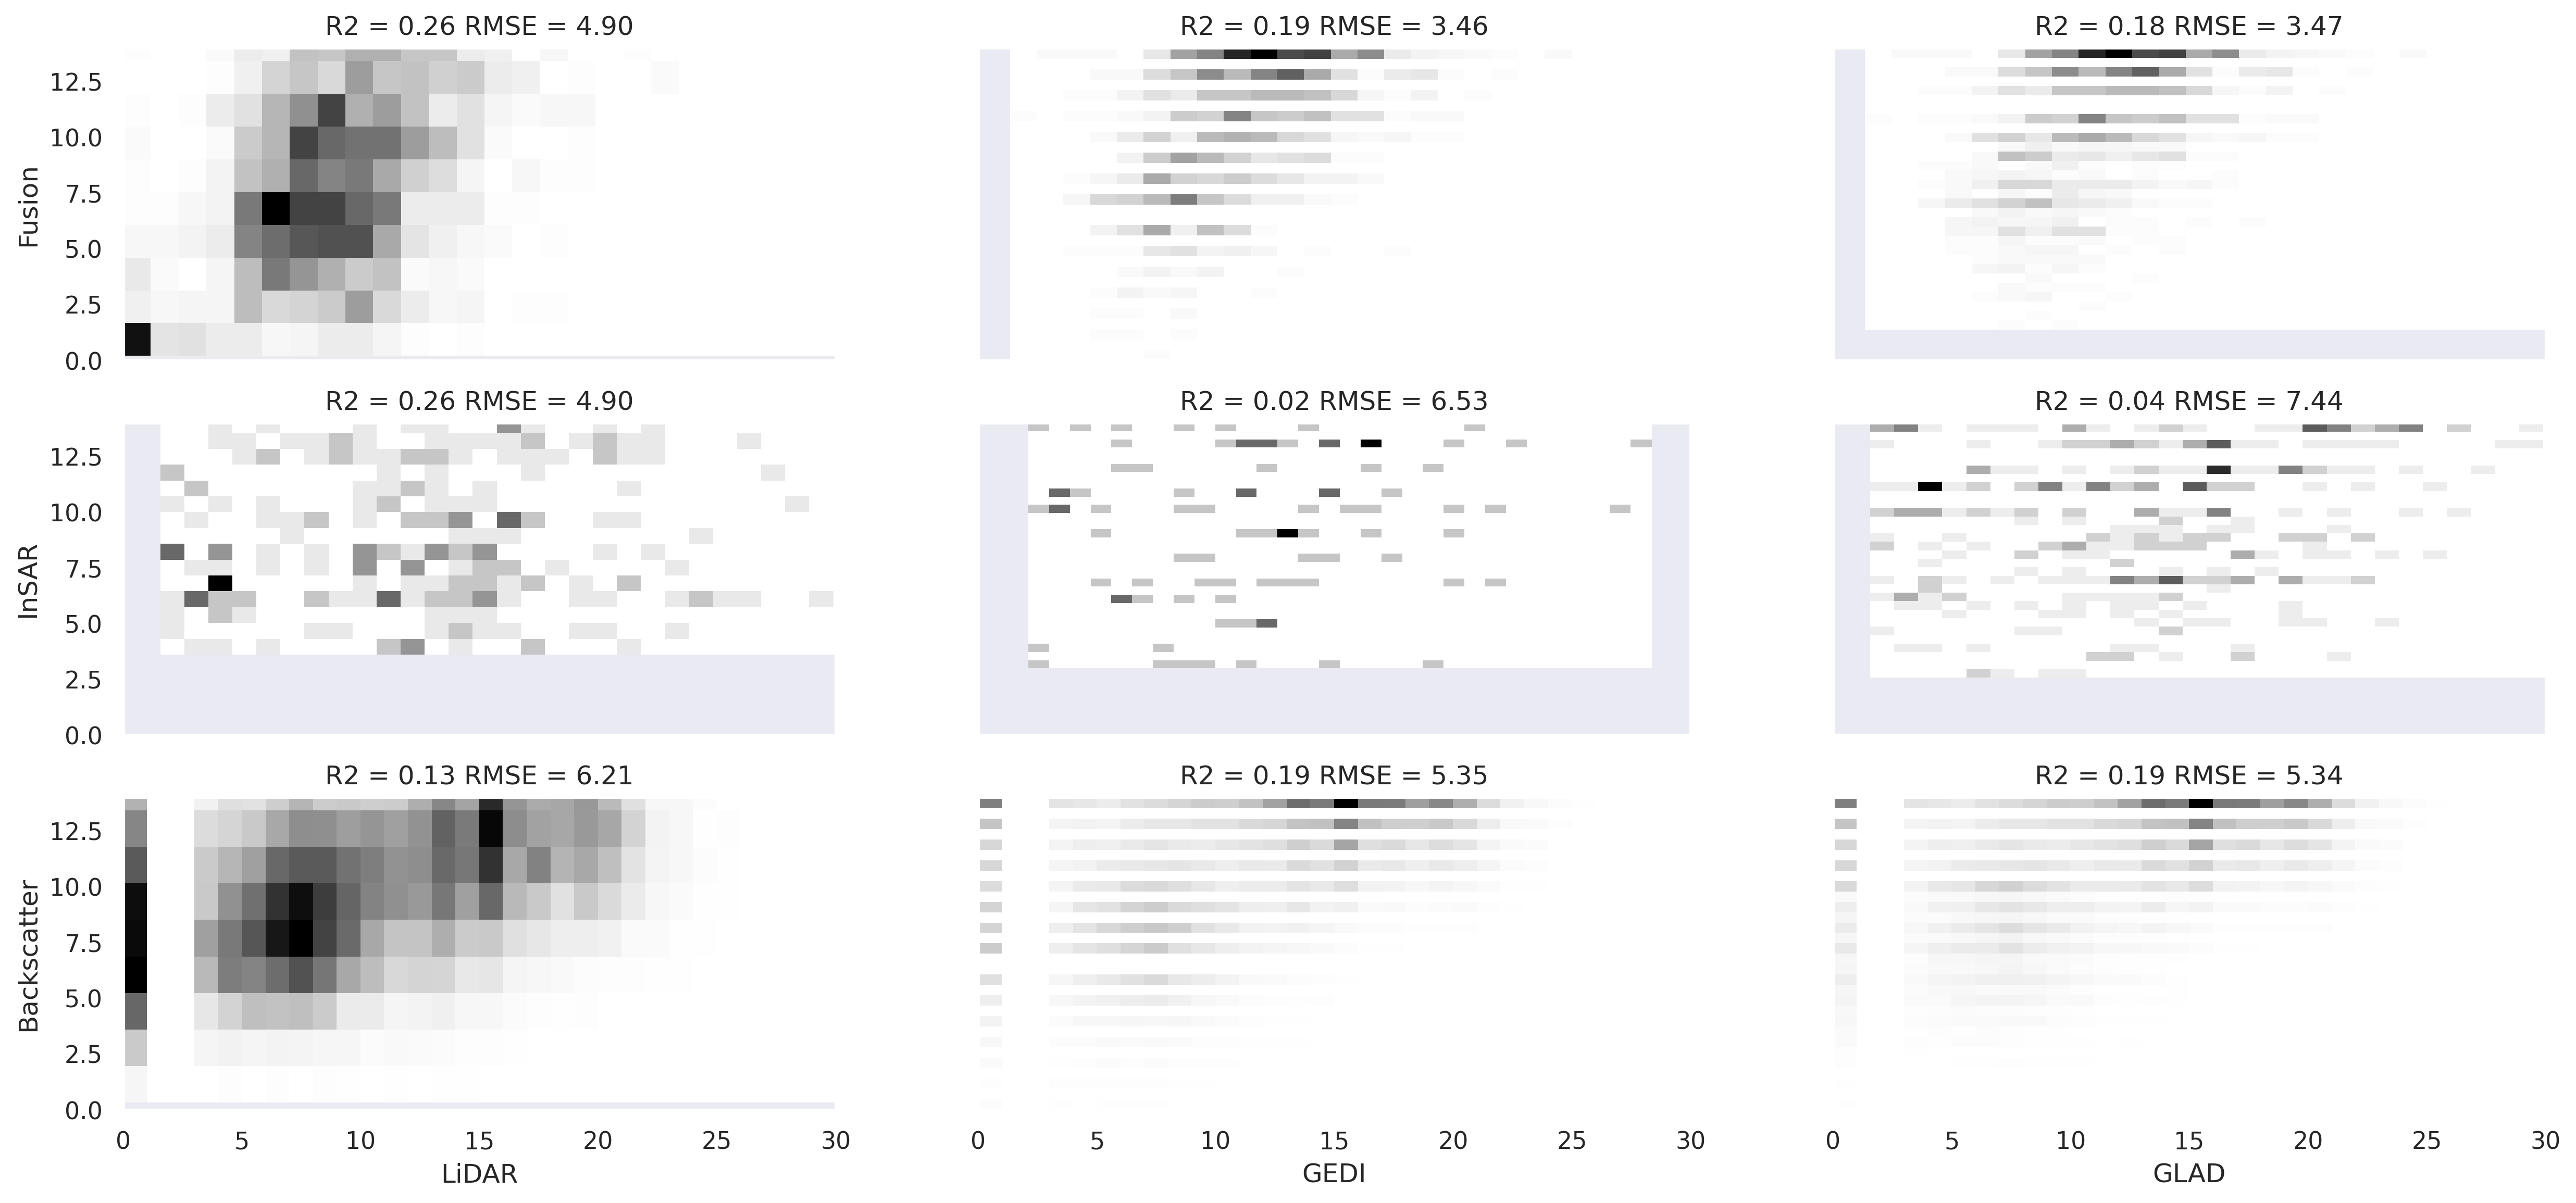

<Figure size 6000x6000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

#set style white
#need colorbar

#https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html

#for ax in axs.flat:
 # im=ax.imshow(np.random.random((10,10)), vmin=0, vmax=40)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

fig.set_figheight(9)
fig.set_figwidth(20)
#fig.suptitle('LiDAR, GEDI, GLAD vs. InSAR, Backscatter, Fusion')
# x axis - comparison datasets
# y axis - our estimated datasets
axs[0, 0].hist2d(xnew_lid_bs, ynew_lid_bs, bins = (30, 30), cmap=plt.cm.Greys) #  testing LiDAR vs backscatter 

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_bs, ynew_lid_bs)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_bs, ynew_lid_bs)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,0].set_title(title)

axs[0, 1].hist2d(xnew_lid_in, ynew_lid_in, bins = (30, 30), cmap=plt.cm.Greys)   # testing LiDAR vs InSAR 2009

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_in, ynew_lid_in)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_in, ynew_lid_in)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,1].set_title(title)

axs[0, 2].hist2d(xnew_lid_fus, ynew_lid_fus, bins = (30, 30), cmap=plt.cm.Greys) #  testing LiDAR vs. Fusion 

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_fus, ynew_lid_fus)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_fus, ynew_lid_fus)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,2].set_title(title)

axs[1, 0].hist2d(xgedi_b, ygedi_b, bins = (30, 30), cmap=plt.cm.Greys) # GEDI backscatter   

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_bs, ynew_lid_bs)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_bs, ynew_lid_bs)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,0].set_title(title)

axs[1, 1].hist2d(xgedi_i, ygedi_i, bins = (30, 30), cmap=plt.cm.Greys) #GEDI InSAR

slope, intercept, r_value, p_value, std_err = stats.linregress(xgedi_i, ygedi_i)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xgedi_i, ygedi_i)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,1].set_title(title)

axs[1, 2].hist2d(xgedi_f, ygedi_f, bins = (30, 30), cmap=plt.cm.Greys) #GEDI vs Fusion

slope, intercept, r_value, p_value, std_err = stats.linregress(xgedi_f, ygedi_f)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xgedi_f, ygedi_f)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,2].set_title(title)

axs[2, 0].hist2d(xglad_b, yglad_b, bins = (30, 30), cmap=plt.cm.Greys) # GLAD vs backscatter

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_b, yglad_b)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_b, yglad_b)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2,0].set_title(title)

axs[2, 1].hist2d(xglad_i, yglad_i, bins = (30, 30), cmap=plt.cm.Greys) #GLAD vs InSAR

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_i, yglad_i)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_i, yglad_i)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2, 1].set_title(title)

axs[2, 2].hist2d(xglad_f, yglad_f, bins = (30, 30), cmap=plt.cm.Greys) # GLAD vs Fusion

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_f, yglad_f)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_f, yglad_f)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2,2].set_title(title)

axs[2, 0].set_xlabel('LiDAR')
axs[2, 1].set_xlabel('GEDI')
axs[2, 2].set_xlabel('GLAD')
axs[2, 0].set_ylabel('Backscatter')
axs[1, 0].set_ylabel('InSAR')
axs[0, 0].set_ylabel('Fusion')

#plt.hist2d(a, b, (50, 50), cmap=plt.cm.jet)
#plt.colorbar()

plt.figure(figsize=(40, 40), dpi = 150) 
plt.show()

This just looks terrible...
could be good to include n = as well as R2 and RMSE

Try three rows of pairplots?
 Lidar vs all, GEDI vs all, GLAD vs all

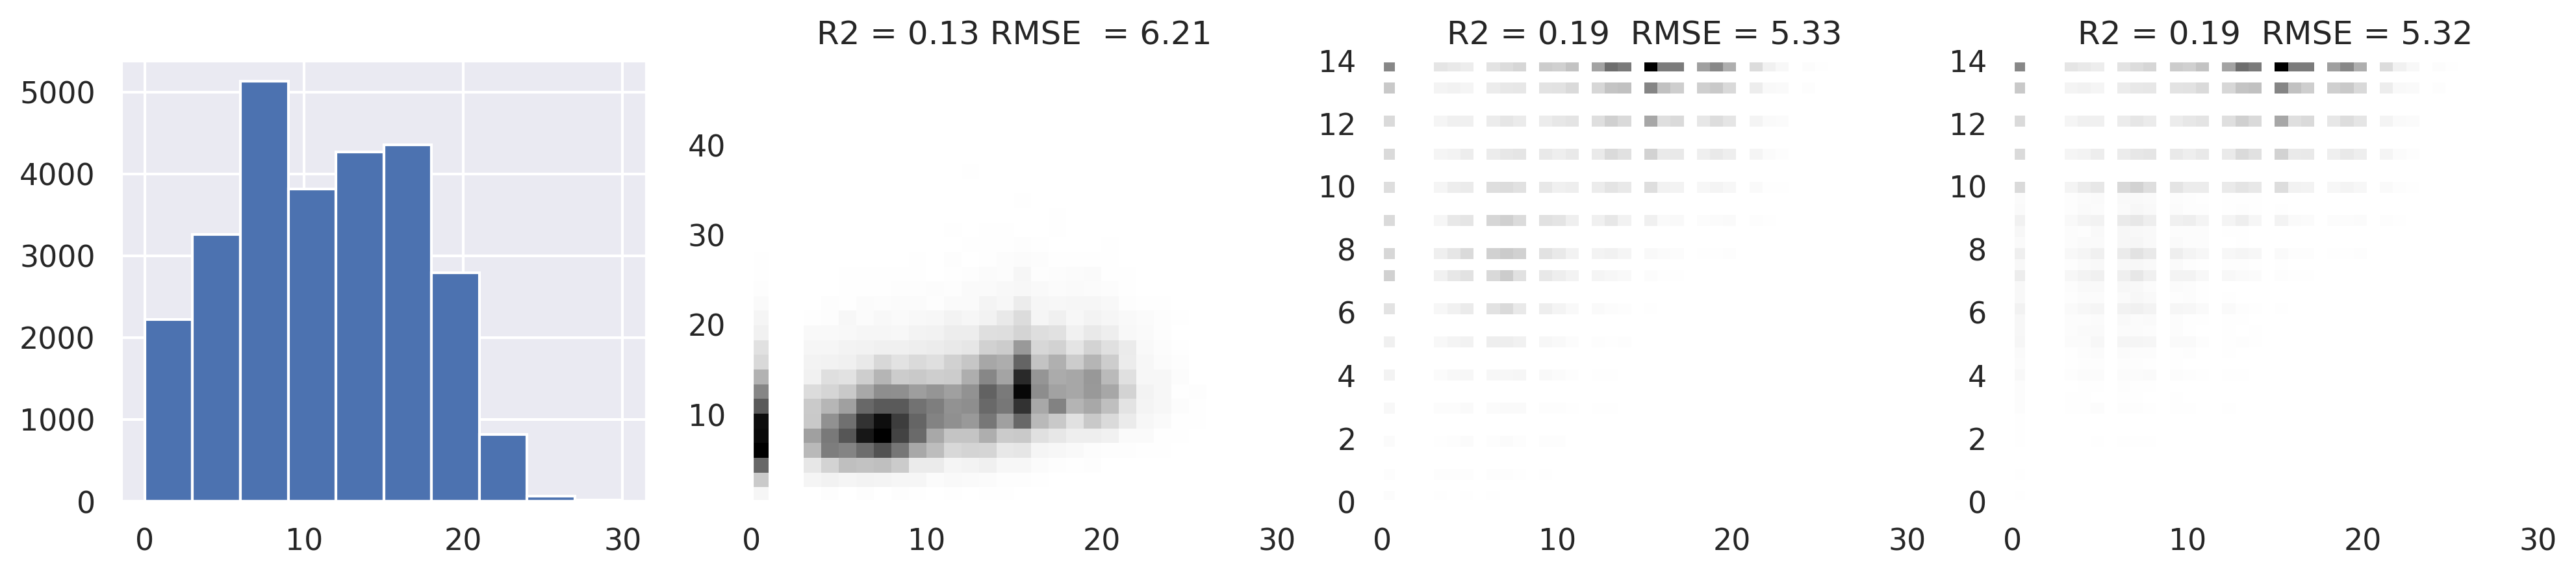

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3))#, sharex=True, sharey=True)

norm = plt.Normalize(glad_dropna['GLAD'].min(), glad_dropna['GLAD'].max())
sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
#sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(glad_dropna['GLAD'].max(), start=.5, rot=-.75,as_cmap=True), norm=norm)
sm.set_array([])

axs[0].hist(glad_dropna['GLAD'])

axs[1].hist2d(glad_dropna['GLAD'], glad_dropna['Backscatter'], bins = (30, 30), cmap=plt.cm.Greys) # GLAD vs backscatter

slope, intercept, r_value, p_value, std_err = stats.linregress(glad_dropna['GLAD'], glad_dropna['Backscatter'])
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(glad_dropna['GLAD'], glad_dropna['Backscatter'])
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE  = " f"{rmse:.2f}"
axs[1].set_title(title)

axs[2].hist2d(glad_dropna["GLAD"], glad_dropna["InSAR"], bins = (40, 40), cmap=plt.cm.Greys) #GLAD vs InSAR

slope, intercept, r_value, p_value, std_err = stats.linregress(glad_dropna["GLAD"], glad_dropna["InSAR"])
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(glad_dropna["GLAD"], glad_dropna["InSAR"])
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + "  RMSE = " f"{rmse:.2f}"
axs[2].set_title(title)

axs[3].hist2d(glad_dropna['GLAD'], glad_dropna['Fusion'], bins = (40, 40), cmap=plt.cm.Greys) # GLAD vs Fusion

slope, intercept, r_value, p_value, std_err = stats.linregress(glad_dropna['GLAD'], glad_dropna['Fusion'])
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(glad_dropna['GLAD'], glad_dropna['Fusion'])
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + "  RMSE = " f"{rmse:.2f}"
axs[3].set_title(title)

cbar = plt.colorbar(sm, ax=ax.axes)
plt.show()

# Boxplot

Grabbing all the values available within the LiDAR area

In [ ]:
data = pd.read_excel("pair_w_GLAD.xlsx")
data2 = pd.read_excel("GEDI_cliptoLiDAR.xlsx")

data_nan = np.where(data<0, np.nan, data)
data_df = pd.DataFrame(data_nan, columns = ['LiDAR', 'GLAD', 'InSAR', 'Backscatter', 'Fusion'])

data2_nan = np.where(data2<0, np.nan, data2)
data2_df = pd.DataFrame(data2_nan, columns = ['height_bin'])

lidar = pd.DataFrame(data_df[['LiDAR']])
glad = pd.DataFrame(data_df[['GLAD']])
insar = pd.DataFrame(data_df[['InSAR']])
backscatter = pd.DataFrame(data_df[['Backscatter']])
fusion = pd.DataFrame(data_df[['Fusion']])

gedi = pd.DataFrame(data2_df['height_bin'])

Get needed values to make boxplot

In [ ]:
stats = gedi.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = count*3.14*12.5*12.5/10000
print("GEDI "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

GEDI count = 415.0 mean = 11.5 std = 6.2 min = 1.4 25% = 6.4 median = 11.6 75% = 15.6 max = 34.3 area =  20.360937500000002


In [ ]:
stats = glad.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = count*6
print("GLAD "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

GLAD count = 869.0 mean = 10.7 std = 5.3 min = 0.0 25% = 7.0 median = 11.0 75% = 15.0 max = 23.0 area =  5214.0


In [ ]:
stats = lidar.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = count*6
print("Lidar "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

Lidar count = 2058.0 mean = 9.4 std = 3.8 min = 0.0 25% = 7.0 median = 9.3 75% = 11.7 max = 35.1 area =  12348.0


In [ ]:
stats = backscatter.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = 6*count
print("Backscatter "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

Backscatter count = 1044.0 mean = 12.5 std = 5.2 min = 1.4 25% = 9.0 median = 11.8 75% = 15.4 max = 44.3 area =  6264.0


In [ ]:
stats = insar.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = count*6
print("INSAR "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

INSAR count = 1108.0 mean = 10.5 std = 3.0 min = 0.0 25% = 8.0 median = 11.0 75% = 13.0 max = 14.0 area =  6648.0


In [ ]:
stats = fusion.describe()
count = stats.iloc[0,0]
mean = stats.iloc[1, 0]
std = stats.iloc[2, 0]
min_ = stats.iloc[3, 0]
first = stats.iloc[4, 0]
median = stats.iloc[5, 0]
third = stats.iloc[6, 0]
max_ = stats.iloc[7, 0]
output_count = f"{count:.1f}"
output_mean = f"{mean:.1f}"
output_std = f"{std:.1f}"
output_min = f"{min_:.1f}"
output_first = f"{first:.1f}"
output_median = f"{median:.1f}"
output_third = f"{third:.1f}"
output_max = f"{max_:.1f}"
area = count*6
print("Fusion "
      "count = " + output_count, "mean = " + output_mean, 
      "std = " + output_std, "min = " + output_min,
      "25% = " + output_first, "median = " + output_median,
      "75% = " + output_third, "max = " + output_max,
      "area = ", area)

Fusion count = 1108.0 mean = 10.6 std = 3.0 min = 1.4 25% = 8.2 median = 11.0 75% = 13.0 max = 14.0 area =  6648.0


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Text(0, 0.5, 'Height (m)')

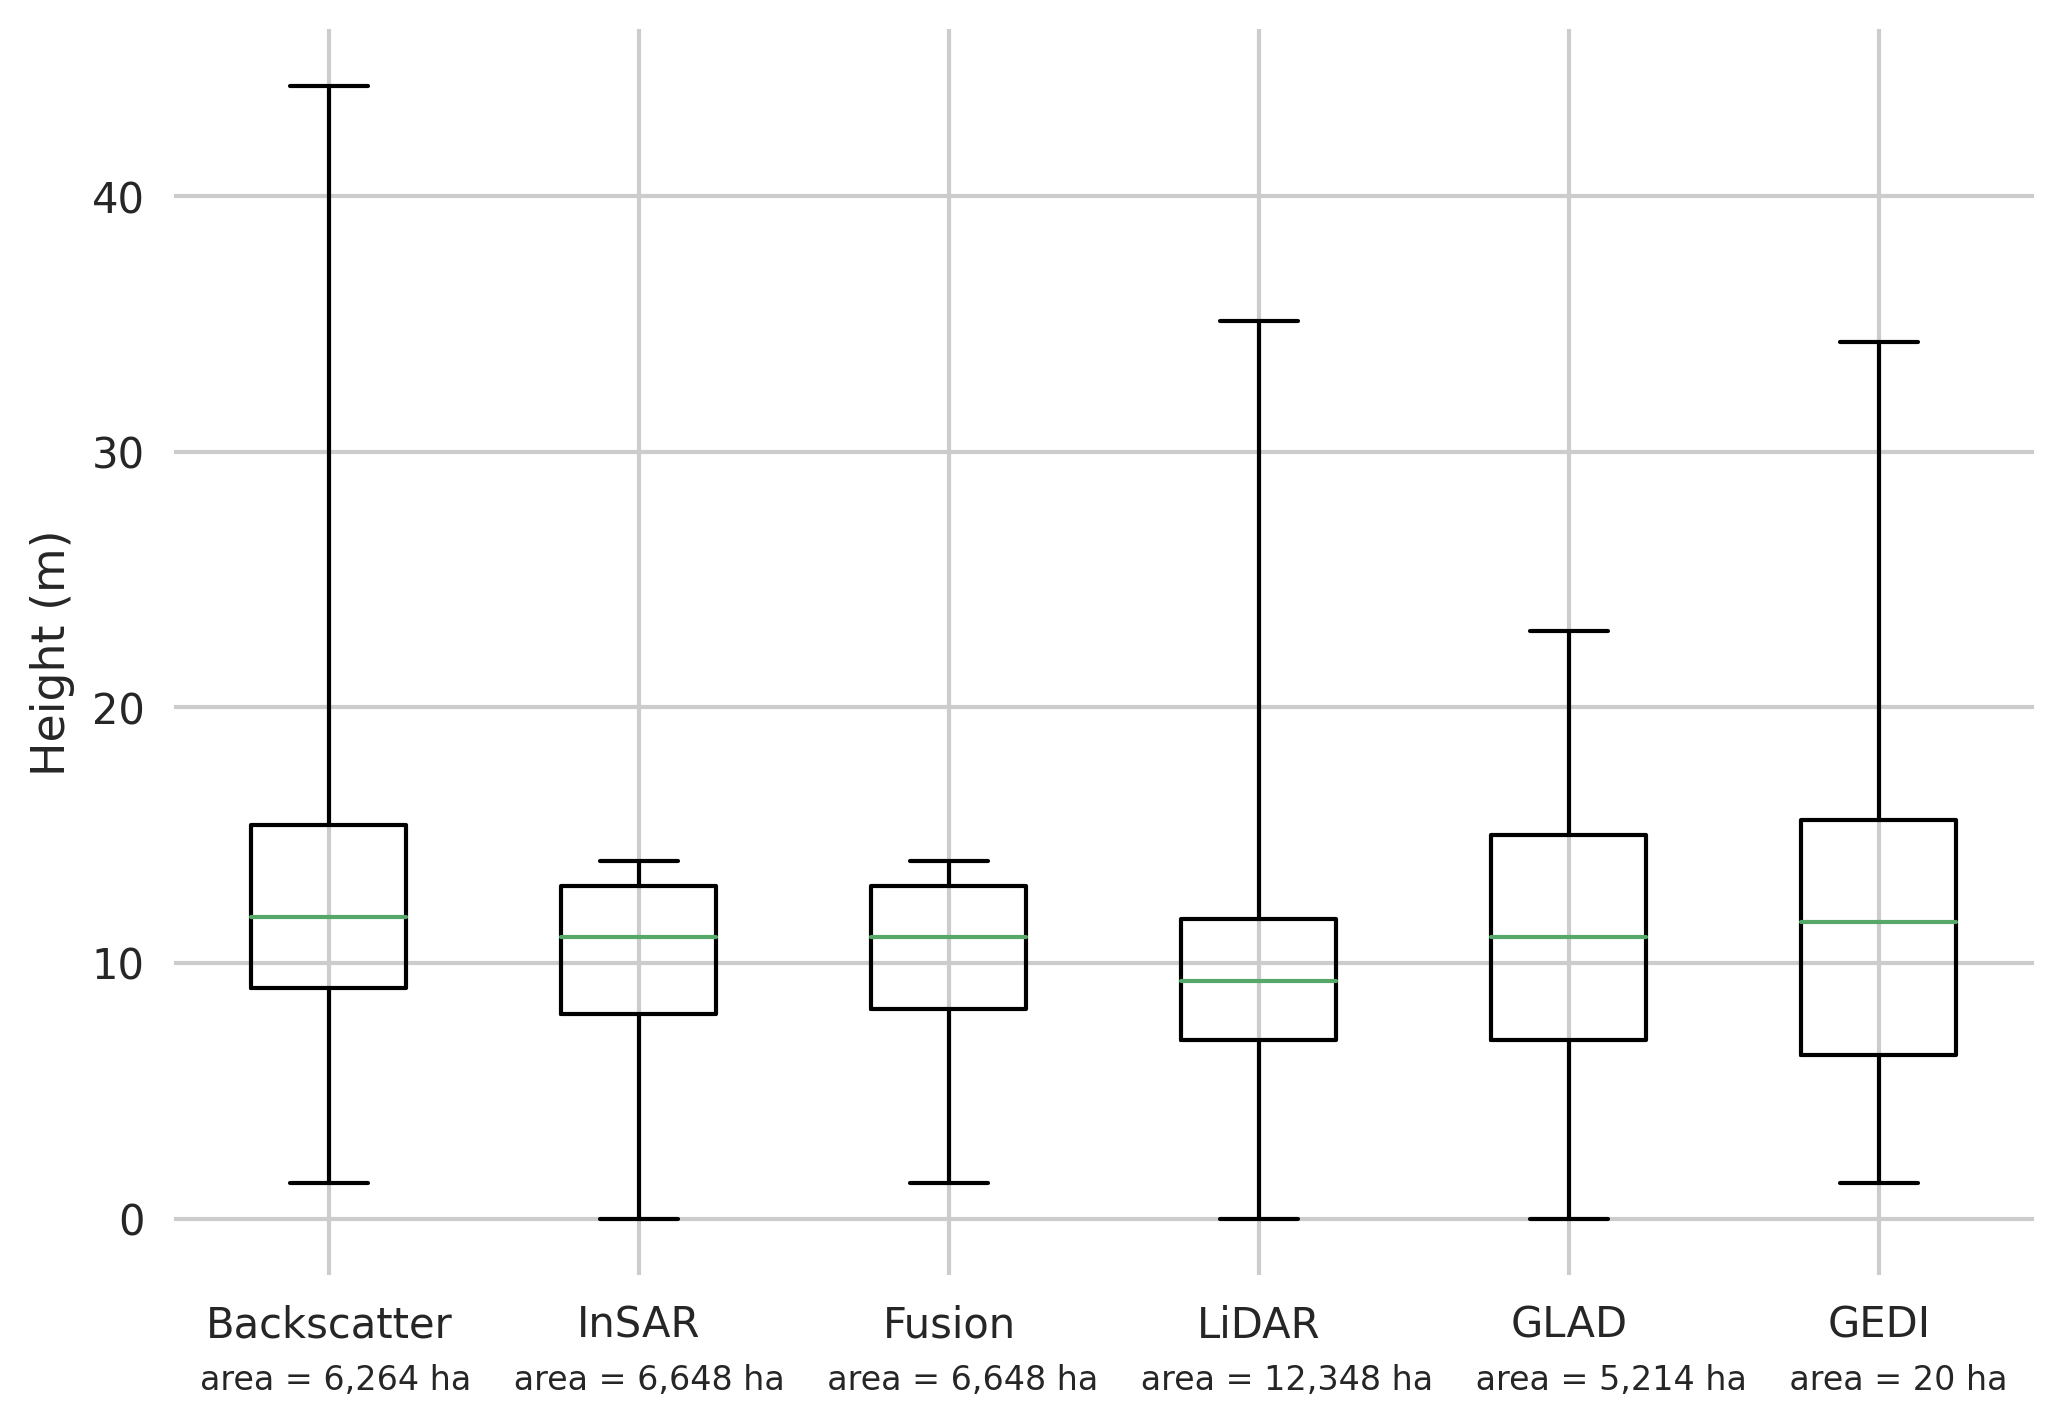

In [ ]:
"""
Updated on Wed June 9 2021

@author: hbaldwin
"""

import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots()
mpl.style.use("seaborn")
sns.set_style("whitegrid")
boxes = [
    {
        'label' : "Backscatter",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 9.0,    # First quartile (25th percentile)
        'med'   : 11.8,    # Median         (50th percentile)
        'q3'    : 15.4,    # Third quartile (75th percentile)
        'whishi': 44.3,    # Top whisker position
        'fliers': []        # Outliers

    },
        {
        #from version v2.5.1 outputs created with training only
        'label' : "InSAR",
        'whislo': 0.0,    # Bottom whisker position
        'q1'    : 8.0,    # First quartile (25th percentile)
        'med'   : 11.0,    # Median         (50th percentile)
        'q3'    : 13.0,    # Third quartile (75th percentile)
        'whishi': 14.0,    # Top whisker position
        'fliers': []        # Outliers

    },
        {
        #version 2.5.1 outputs and v17 for backscatter
        'label' : "Fusion",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 8.2,    # First quartile (25th percentile)
        'med'   : 11.0,    # Median         (50th percentile)
        'q3'    : 13.0,    # Third quartile (75th percentile)
        'whishi': 14.0,    # Top whisker position
        'fliers': []        # Outliers

    }, 
        {
        'label' : "LiDAR",
        'whislo': 0.0,    # Bottom whisker position
        'q1'    : 7.0,    # First quartile (25th percentile)
        'med'   : 9.3,    # Median         (50th percentile)
        'q3'    : 11.7,    # Third quartile (75th percentile)
        'whishi': 35.1,    # Top whisker position
        'fliers': []        # Outliers
    },
        
#        {
#        'label' : "in situ",
#        'whislo': 0,    # Bottom whisker position
#        'q1'    : 10.0,    # First quartile (25th percentile)
#        'med'   : 13.7,    # Median         (50th percentile)
#        'q3'    : 15.8,    # Third quartile (75th percentile)
#        'whishi': 24.5,    # Top whisker position
#        'fliers': []        # Outliers

#    },
        {
        'label' : "GLAD",
        'whislo': 0.0,    # Bottom whisker position
        'q1'    : 7.0,    # First quartile (25th percentile)
        'med'   : 11.0,    # Median         (50th percentile)
        'q3'    : 15.0,    # Third quartile (75th percentile)
        'whishi': 23.0,    # Top whisker position
        'fliers': []        # Outliers

    },   
        {
        'label' : "GEDI",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 6.4,    # First quartile (25th percentile)
        'med'   : 11.6,   # Median         (50th percentile)
        'q3'    : 15.6,   # Third quartile (75th percentile)
        'whishi': 34.3,     # Top whisker position
        'fliers': []        # Outliers

    }
    
]

ax.set_xlabel('area = 6,264 ha    area = 6,648 ha    area = 6,648 ha    area = 12,348 ha    area = 5,214 ha    area = 20 ha', fontsize=8)
ax.bxp(boxes, showfliers=False)
ax.set_ylabel("Height (m)")
#plt.figure(dpi = 400) 
#plt.savefig("All_Boxplots_06_09_2021.png")

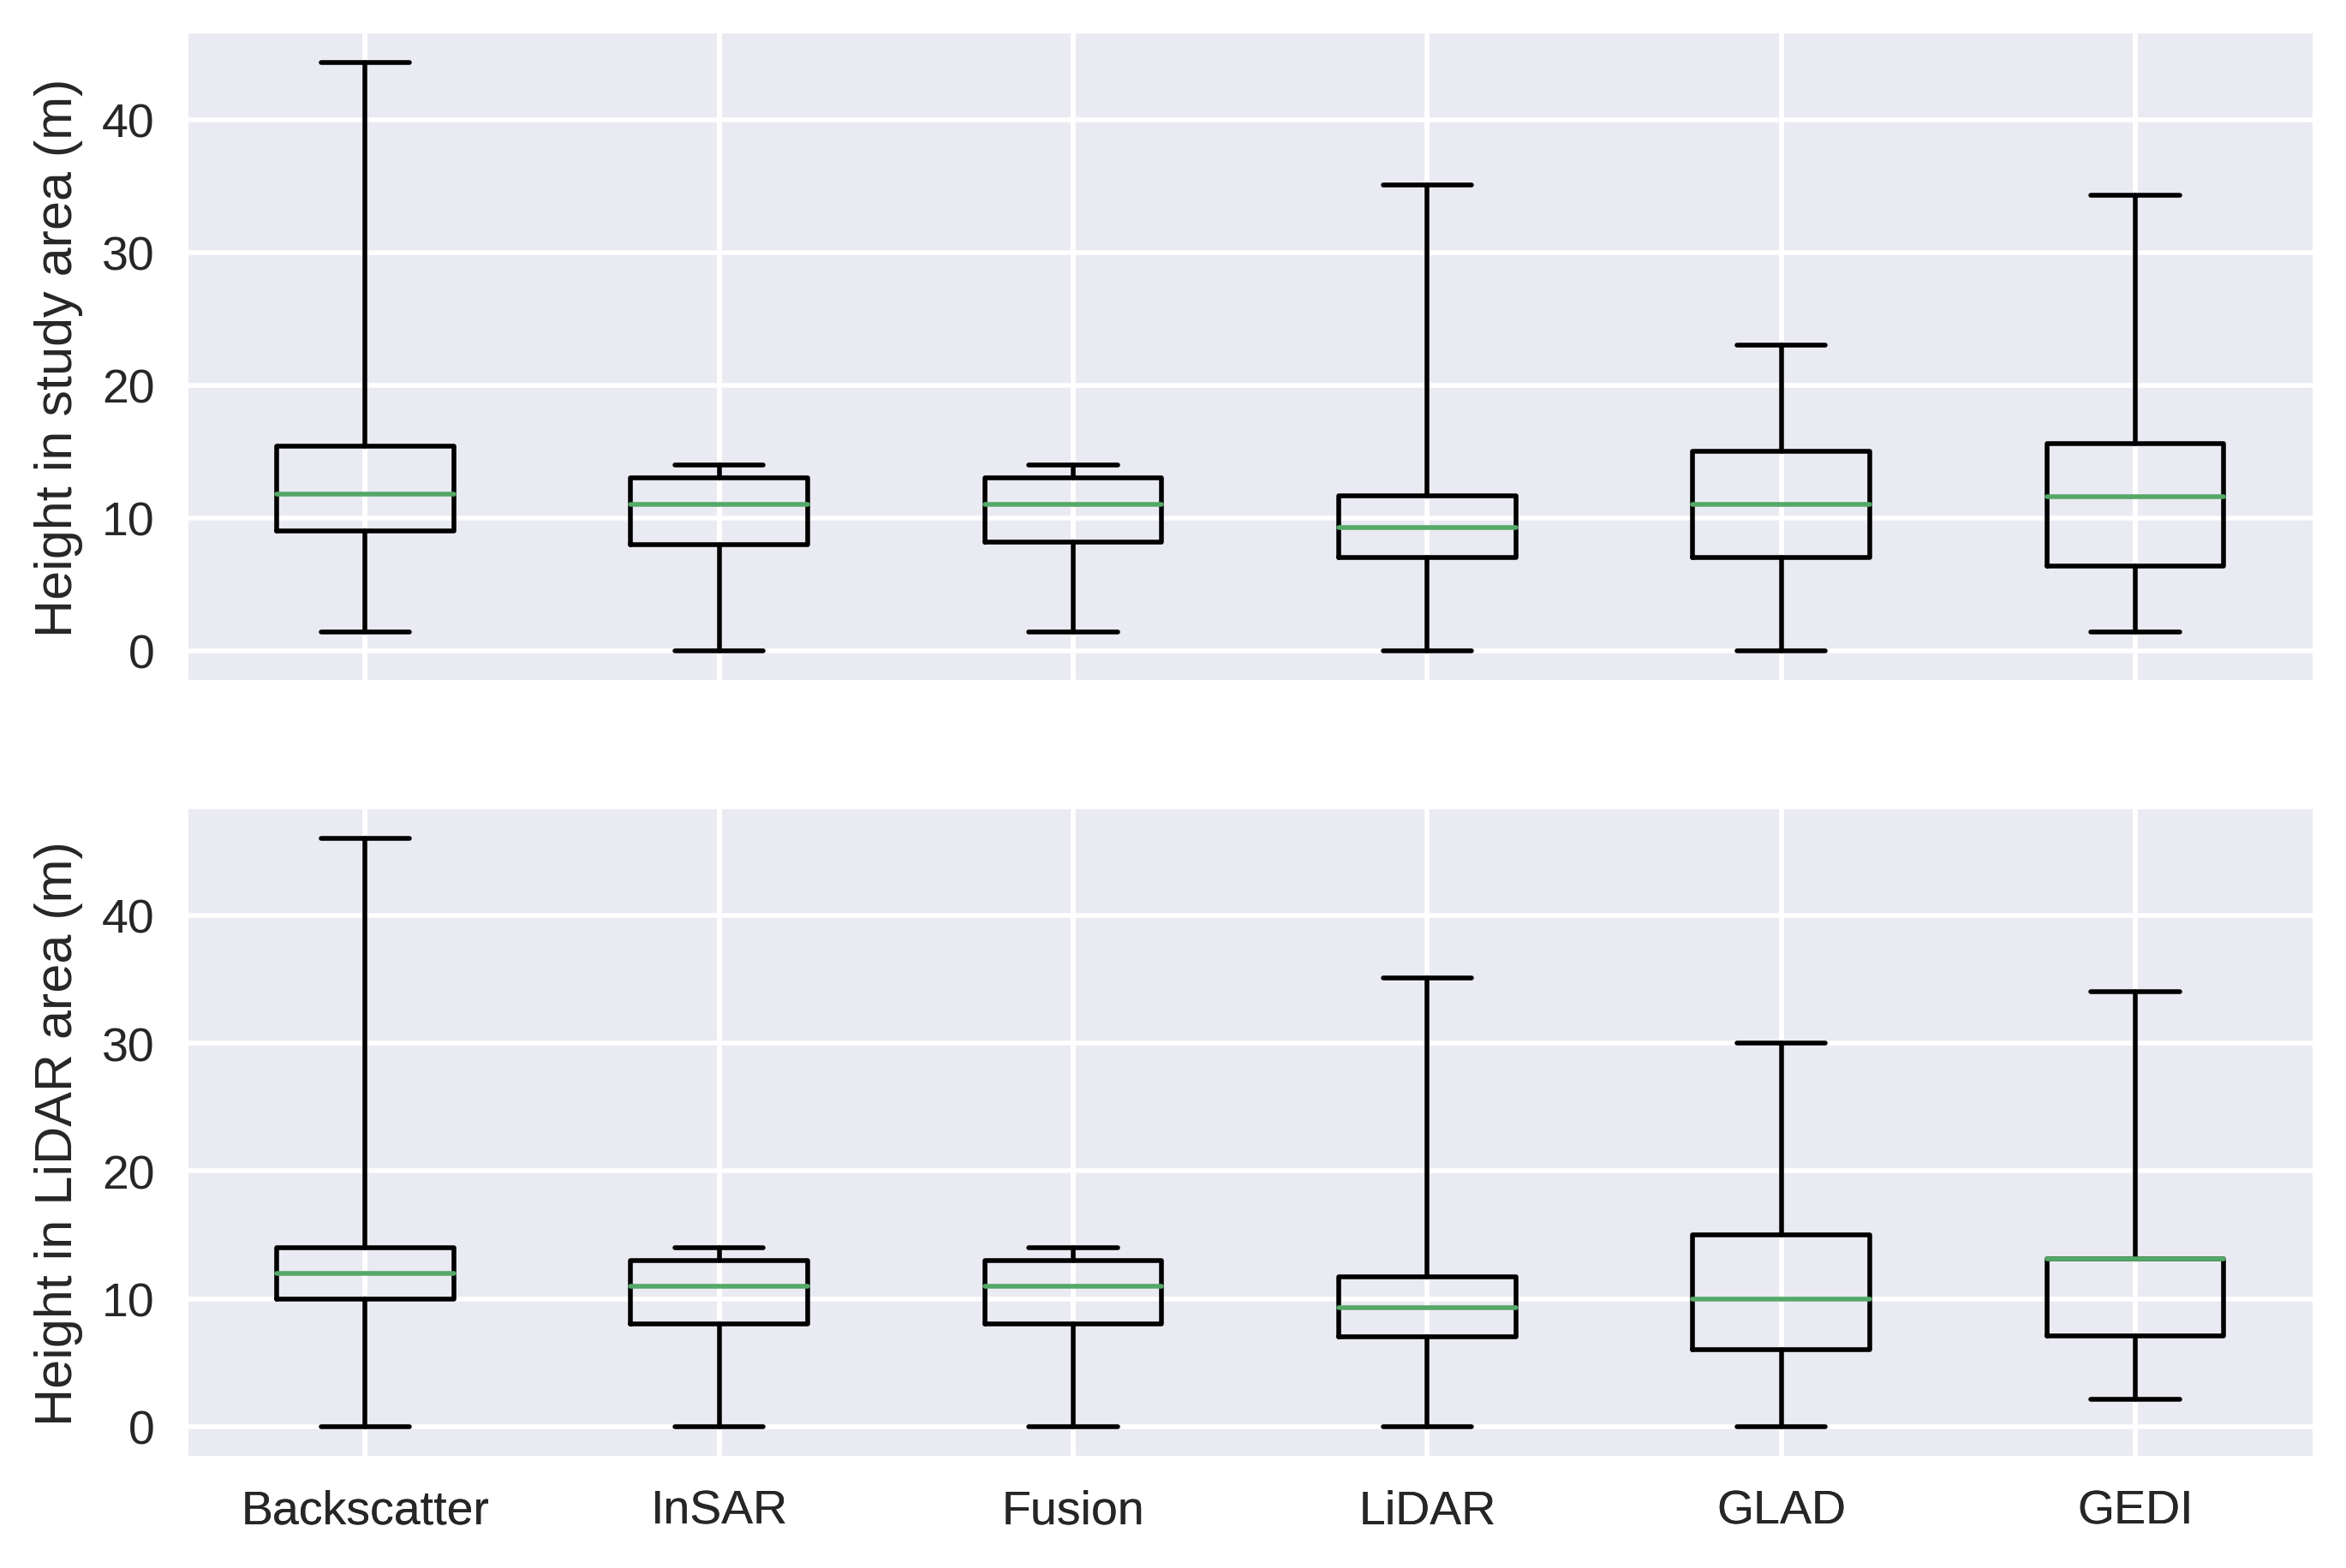

<Figure size 3200x2200 with 0 Axes>

In [ ]:
"""
Created on Tue Nov 17 17:49:49 2020

Updated April 18, 2021

@author: hbaldwin
"""

import matplotlib.pyplot as plt
import matplotlib as mpl

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
mpl.style.use("seaborn")
boxes = [
    {
        'label' : "Backscatter",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 10,    # First quartile (25th percentile)
        'med'   : 12,    # Median         (50th percentile)
        'q3'    : 14,    # Third quartile (75th percentile)
        'whishi': 46,    # Top whisker position
        'fliers': []        # Outliers

    },
        {
        #version v2.5.1 outputs, with training only
        'label' : "InSAR",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 8,    # First quartile (25th percentile)
        'med'   : 11,    # Median         (50th percentile)
        'q3'    : 13,    # Third quartile (75th percentile)
        'whishi': 14,    # Top whisker position
        'fliers': []        # Outliers

    },
        {
        #version 2.5.1 outputs and v17 for backscatter
        'label' : "Fusion",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 8,    # First quartile (25th percentile)
        'med'   : 11,    # Median         (50th percentile)
        'q3'    : 13,    # Third quartile (75th percentile)
        'whishi': 14,    # Top whisker position
        'fliers': []        # Outliers

    }, 
        {
        'label' : "LiDAR",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 7.0,    # First quartile (25th percentile)
        'med'   : 9.3,    # Median         (50th percentile)
        'q3'    : 11.7,    # Third quartile (75th percentile)
        'whishi': 35.1,    # Top whisker position
        'fliers': []        # Outliers
    },
        
#        {
#        'label' : "in situ",
#        'whislo': 0,    # Bottom whisker position
#        'q1'    : 10.0,    # First quartile (25th percentile)
#        'med'   : 13.7,    # Median         (50th percentile)
#        'q3'    : 15.8,    # Third quartile (75th percentile)
#        'whishi': 24.5,    # Top whisker position
#        'fliers': []        # Outliers
#
#    },
        {
        'label' : "GLAD",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 6,    # First quartile (25th percentile)
        'med'   : 10,    # Median         (50th percentile)
        'q3'    : 15,    # Third quartile (75th percentile)
        'whishi': 30,    # Top whisker position
        'fliers': []        # Outliers

    },  
        {
        'label' : "GEDI",
        'whislo': 2.1,    # Bottom whisker position
        'q1'    : 7.1,    # First quartile (25th percentile)
        'med'   : 13.1,   # Median         (50th percentile)
        'q3'    : 13.1,   # Third quartile (75th percentile)
        'whishi': 34,     # Top whisker position
        'fliers': []        # Outliers

    }
    
]

boxes_lidar = [
          


                   {
        'label' : "Backscatter",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 9,    # First quartile (25th percentile)
        'med'   : 11.8,    # Median         (50th percentile)
        'q3'    : 15.4,    # Third quartile (75th percentile)
        'whishi': 44.3,    # Top whisker position
        'fliers': []        # Outliers
        #count = 1044.0 
        #mean = 12.5 
        #std = 5.2 

    },
        {
        #version v2.5.1 outputs, with training only
        'label' : "InSAR",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 8,    # First quartile (25th percentile)
        'med'   : 11,    # Median         (50th percentile)
        'q3'    : 13,    # Third quartile (75th percentile)
        'whishi': 14,    # Top whisker position
        'fliers': []        # Outliers
         #count = 1108.0 
         #mean = 10.5 
         #std = 3.0 

    },
        {
        #version 2.5.1 outputs and v17 for backscatter
        'label' : "Fusion",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 8.2,    # First quartile (25th percentile)
        'med'   : 11.0,    # Median         (50th percentile)
        'q3'    : 13.0,    # Third quartile (75th percentile)
        'whishi': 14.0,    # Top whisker position
        'fliers': []        # Outliers
         #count = 1108.0 
         #mean = 10.6 
         #std = 3.0 


    },           
        {
        'label' : "LiDAR",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 7.0,    # First quartile (25th percentile)
        'med'   : 9.3,    # Median         (50th percentile)
        'q3'    : 11.7,    # Third quartile (75th percentile)
        'whishi': 35.1,    # Top whisker position
        'fliers': []        # Outliers
         #count = 2058
         #mean = 9.4
         #std = 3.8
    },

 

            {
        'label' : "GLAD",
        'whislo': 0,    # Bottom whisker position
        'q1'    : 7,    # First quartile (25th percentile)
        'med'   : 11,    # Median         (50th percentile)
        'q3'    : 15,    # Third quartile (75th percentile)
        'whishi': 23,    # Top whisker position
        'fliers': []        # Outliers
        #count = 869.0 
        #mean = 10.7 
        #std = 5.3 
    }, 
        {
        'label' : "GEDI",
        'whislo': 1.4,    # Bottom whisker position
        'q1'    : 6.4,    # First quartile (25th percentile)
        'med'   : 11.6,   # Median         (50th percentile)
        'q3'    : 15.6,   # Third quartile (75th percentile)
        'whishi': 34.3,     # Top whisker position
        'fliers': []        # Outliers
        }
        #count = 415.0 mean = 11.5 std = 6.2    
]

ax1.bxp(boxes_lidar, showfliers=False)
ax1.set_ylabel("Height in study area (m)")
ax2.bxp(boxes)
ax2.set_ylabel("Height in LiDAR area (m)")
plt.figure(dpi = 400) 
plt.show()

# Multiple 1-line pairwise test

## LiDAR Comparison Data Prep

In [ ]:
#lidar vs backscatter, insar, fusion

lidar_testing = "LiDAR_testing.tif"
lidar = gdal.Open(lidar_testing)
xlidar = lidar.ReadAsArray()

backscatter = "test_EstimatedHeight_resamp_6ha_curvefit_v17.tif"
bs_FSH = gdal.Open(backscatter)
bs = bs_FSH.ReadAsArray()

insar_2009 = "insar_2009_testing.tif"
insar = gdal.Open(insar_2009)
insartest = insar.ReadAsArray()

fusion = "fusion_v3_testing.tif"
f_FSH = gdal.Open(fusion)
fus = f_FSH.ReadAsArray()
y_fus = np.array(fus).ravel()
fustest = np.where(y_fus<0, np.NaN, y_fus)

#print(bs.shape)
#print(xlidar.shape)
#print(insartest.shape)
#print(fustest.shape)

#ravel all
x_lid = np.array(xlidar).ravel()
y_bs = np.array(bs).ravel()
y_insar = np.array(insartest).ravel()
y_fus = np.array(fustest).ravel()

#pandas dataframe and set column name
lidar_df = pd.DataFrame(x_lid, columns = ['LiDAR'])
bs_df = pd.DataFrame(y_bs, columns = ['Backscatter'])
insar_df = pd.DataFrame(y_insar, columns=['InSAR'])
fus_df = pd.DataFrame(y_fus, columns=['Fusion'])

#print(lidar_df)
#print(bs_df)
#print(insar_df)
#print(fus_df)

#concatenate into one pandas dataframe
data_lidar = pd.concat([lidar_df, bs_df, insar_df, fus_df], axis=1)
#print(data_lidar)

#set nan values
lidar_nan2 = np.where(data_lidar<0, np.NaN, data_lidar)
lidar_nan = np.where(lidar_nan2>254, np.nan, lidar_nan2)

#pandas df again
lidar_nan_df = pd.DataFrame(lidar_nan, columns=['LiDAR', 'Backscatter', 'InSAR', 'Fusion'])

#drop nan values
lidar_dropna = lidar_nan_df.dropna()
print(lidar_dropna.head())


         LiDAR  Backscatter  InSAR  Fusion
279   9.910697     6.765002   14.0    14.0
384  15.283643    26.474470   14.0    14.0
385  14.615015    20.527908   14.0    14.0
389  16.701178    15.608514   14.0    14.0
427   9.532679    13.406869   14.0    14.0


In [ ]:
len (lidar_dropna['LiDAR'])

1108

In [ ]:
 
# Using 'Address' as the column name
# and equating it to the list
#lidar_dropna['Hue'] = 'hue'
lidar_dropna = lidar_dropna.assign(H='hue')
print(lidar_dropna.head())

         LiDAR  Backscatter  InSAR  Fusion  Hue    H
279   9.910697     6.765002   14.0    14.0  hue  hue
384  15.283643    26.474470   14.0    14.0  hue  hue
385  14.615015    20.527908   14.0    14.0  hue  hue
389  16.701178    15.608514   14.0    14.0  hue  hue
427   9.532679    13.406869   14.0    14.0  hue  hue


##LIDAR Pairplot Scatter

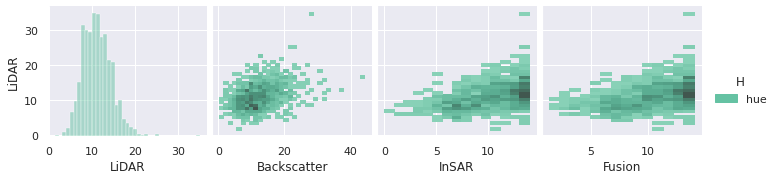

In [ ]:
sns.pairplot(
    lidar_dropna, kind="hist",
    hue="H",
    palette="BuGn",
    x_vars=["LiDAR", "Backscatter", "InSAR", "Fusion"],
    y_vars=["LiDAR"],
)

## LiDAR Pairplot Basic Density

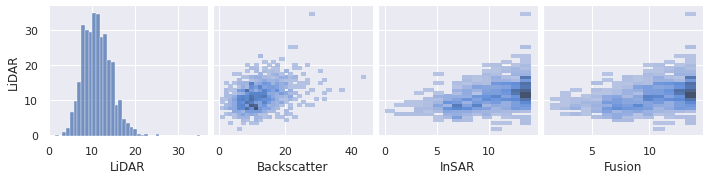

In [ ]:
sns.pairplot(
    lidar_dropna, kind="hist",
    x_vars=["LiDAR", "Backscatter", "InSAR", "Fusion"],
    y_vars=["LiDAR"],
)

##LiDAR comparison, w colorbar and metrics

23.0
39.0
39.0
39.0
39.0
39.0 5.234882204903827 3.4550749507563854 3.469114267278966 0.13065080016811098 0.19489773061420398 0.18027057475663238
1108


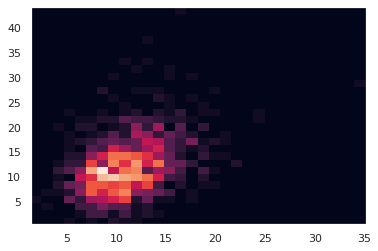

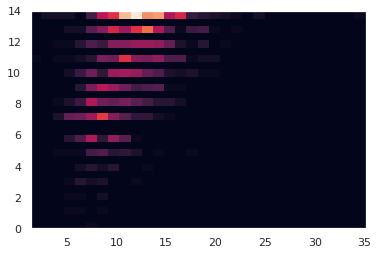

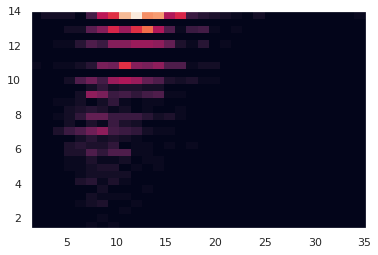

In [ ]:
x = lidar_dropna['LiDAR']
y1 = lidar_dropna['Backscatter']
y2 = lidar_dropna['InSAR']
y3 = lidar_dropna['Fusion']

#calculate metrics

#count for histogram
index = lidar_dropna.index
number_of_rows = len(index)

#R2 and RMSE for each comparison
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
statsR2_1 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y1)
rmse_1 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
statsR2_2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y2)
rmse_2 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y3)
statsR2_3 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y3)
rmse_3 = math.sqrt(mse)

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y1, bins=30)
counts_max1 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y2, bins=30)
counts_max2 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y3, bins=30)
counts_max3 = counts.max()

counts_max_next = 0
counts_max_last = 0

if counts_max1 > counts_max2:
  counts_max_next = counts_max1

else:
  counts_max_next = counts_max2

if counts_max_next > counts_max3:
  counts_max_last = count_max_next

else:
  counts_max_last = counts_max3

print(counts_max1)
print(counts_max2)
print(counts_max3)

print(counts_max_next)
print(counts_max_last)

print(counts_max_last, rmse_1, rmse_2, rmse_3, statsR2_1, statsR2_2, statsR2_3)
print(number_of_rows)

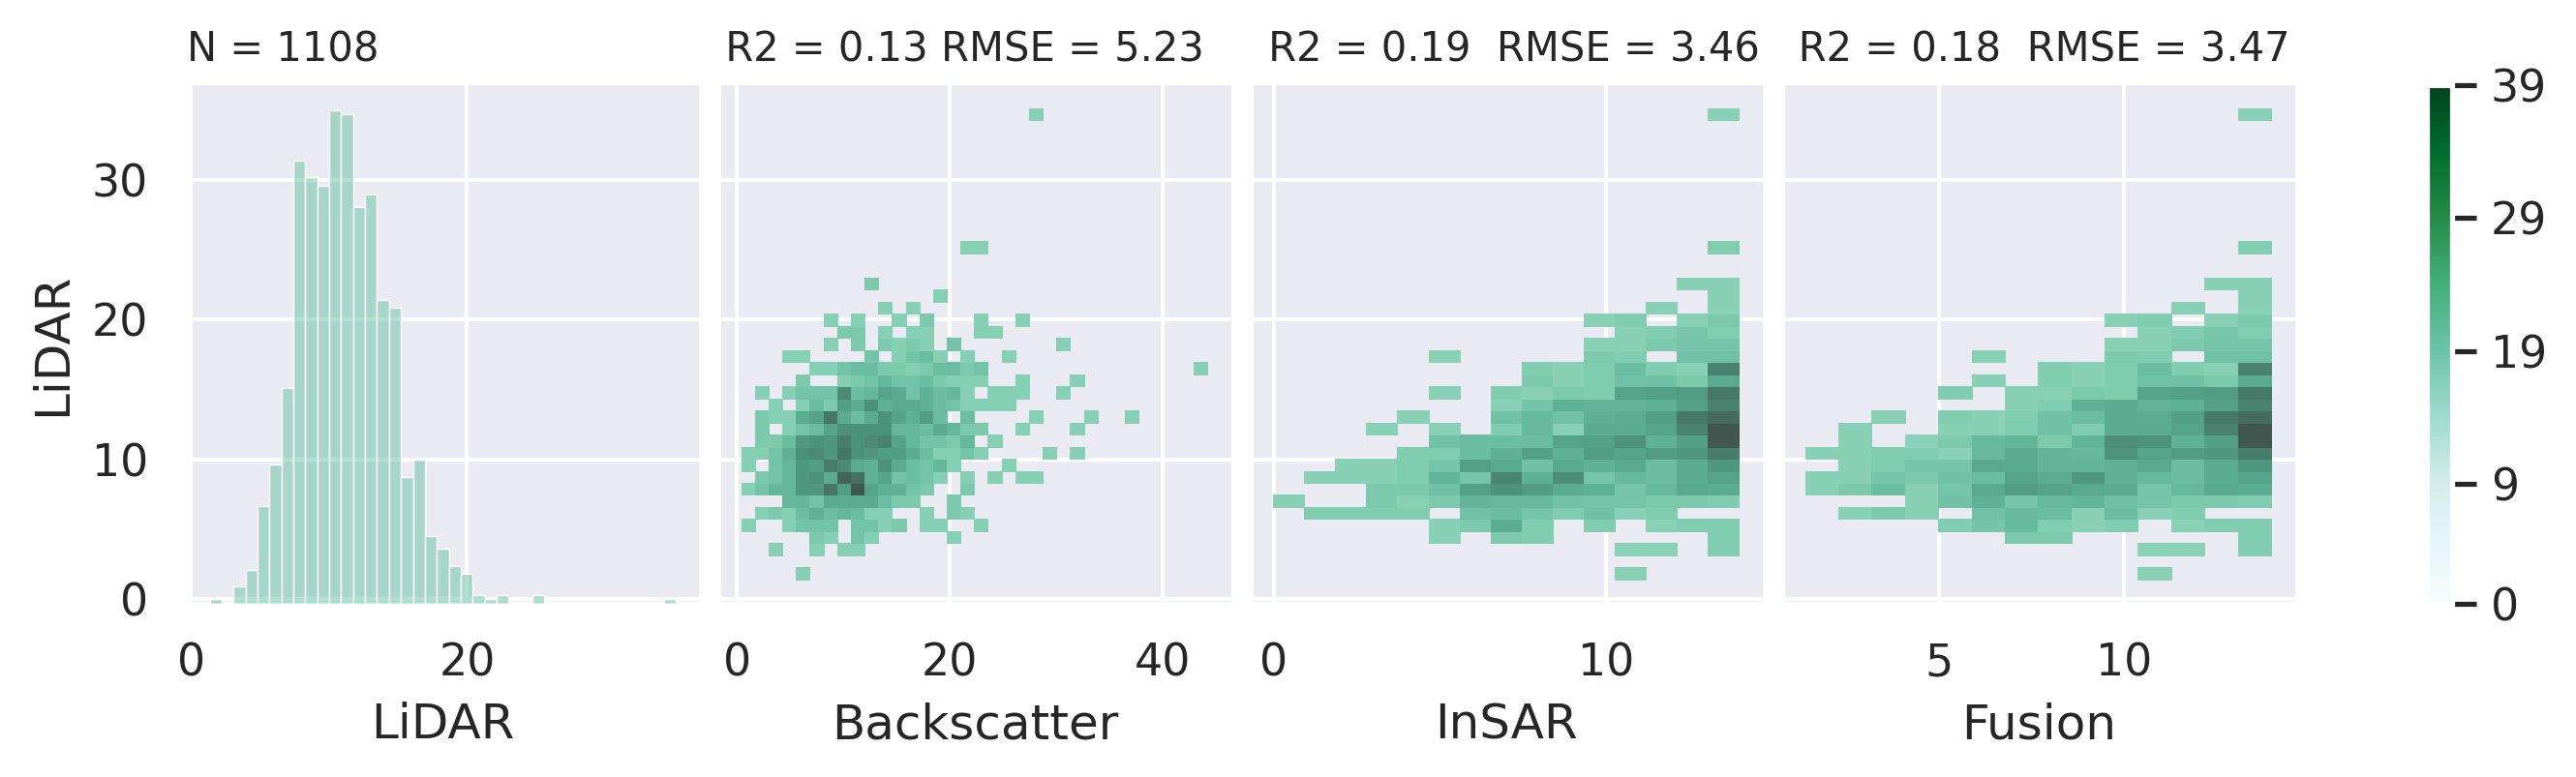

In [ ]:
title = "N = " + f"{number_of_rows:.0f}" + "                           R2 = " + f"{statsR2_1:.2f}" + " RMSE = " f"{rmse_1:.2f}"+ "     R2 = " + f"{statsR2_2:.2f}" + "  RMSE = " f"{rmse_2:.2f}"+ "   R2 = " + f"{statsR2_3:.2f}" + "  RMSE = " f"{rmse_3:.2f}"

norm = plt.Normalize(0, counts_max_last)
sm = plt.cm.ScalarMappable(cmap="BuGn", norm=norm)
sm.set_array([])

ax = sns.pairplot(
    lidar_dropna, kind="hist",
    hue="H",
    palette="BuGn",
    x_vars=["LiDAR", "Backscatter", "InSAR", "Fusion"],
    y_vars=["LiDAR"],
)

ax._legend.remove()

cbar = plt.colorbar(sm, ax=ax.axes)

m0=int(0)                                 # colorbar min value
m4=int(counts_max_last)                   # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)                # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)                # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)                # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

plt.title(title, loc='left', fontsize=10)
mpl.rcParams['figure.dpi'] = 400
plt.show()

##GEDI Comparison Data Prep

In [ ]:
#xgedi_b is the GEDI for the backscatter comparison
#ygedi_b is the corresponding backscatter
gedi_comp = pd.read_excel("pair_GEDI.xlsx")

gedi_nan = np.where(gedi_comp<0, np.nan, gedi_comp)
gedi_df = pd.DataFrame(gedi_nan, columns = ['GEDI', 'InSAR', 'Backscatter', 'Fusion'])

gedi_dropna = gedi_df.dropna()
gedi_dropna = gedi_dropna.assign(H='hue')
print(gedi_dropna.head())

          GEDI  InSAR  Backscatter  Fusion    H
68    6.140793   12.0    23.502199    12.0  hue
69   18.877886   12.0    23.502199    12.0  hue
149   3.705787   11.0     5.636810    11.0  hue
150   3.668325   11.0     5.636810    11.0  hue
617  20.324636    7.0    12.707000     7.0  hue


## GEDI Pairplot Scatter

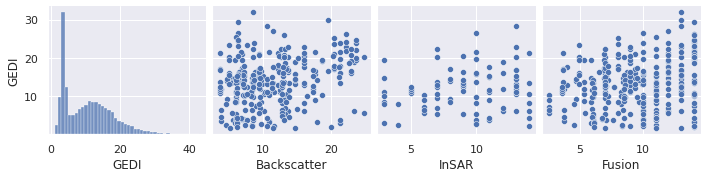

In [ ]:
sns.pairplot(
    gedi_df,
    x_vars=["GEDI", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GEDI"],
)

## GEDI Basic Density

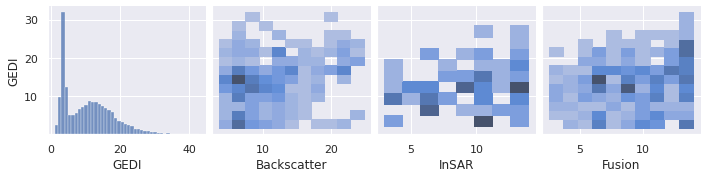

In [ ]:
sns.pairplot(
    gedi_df, kind="hist",
    x_vars=["GEDI", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GEDI"],
)

##GEDI comparison, with colorbar and metrics

2.0
3.0
3.0
3.0
3.0
3.0 7.198623862722811 6.91672105442519 6.896321995971755 0.033198763449606046 0.01605930737228595 0.010159528394703635
76


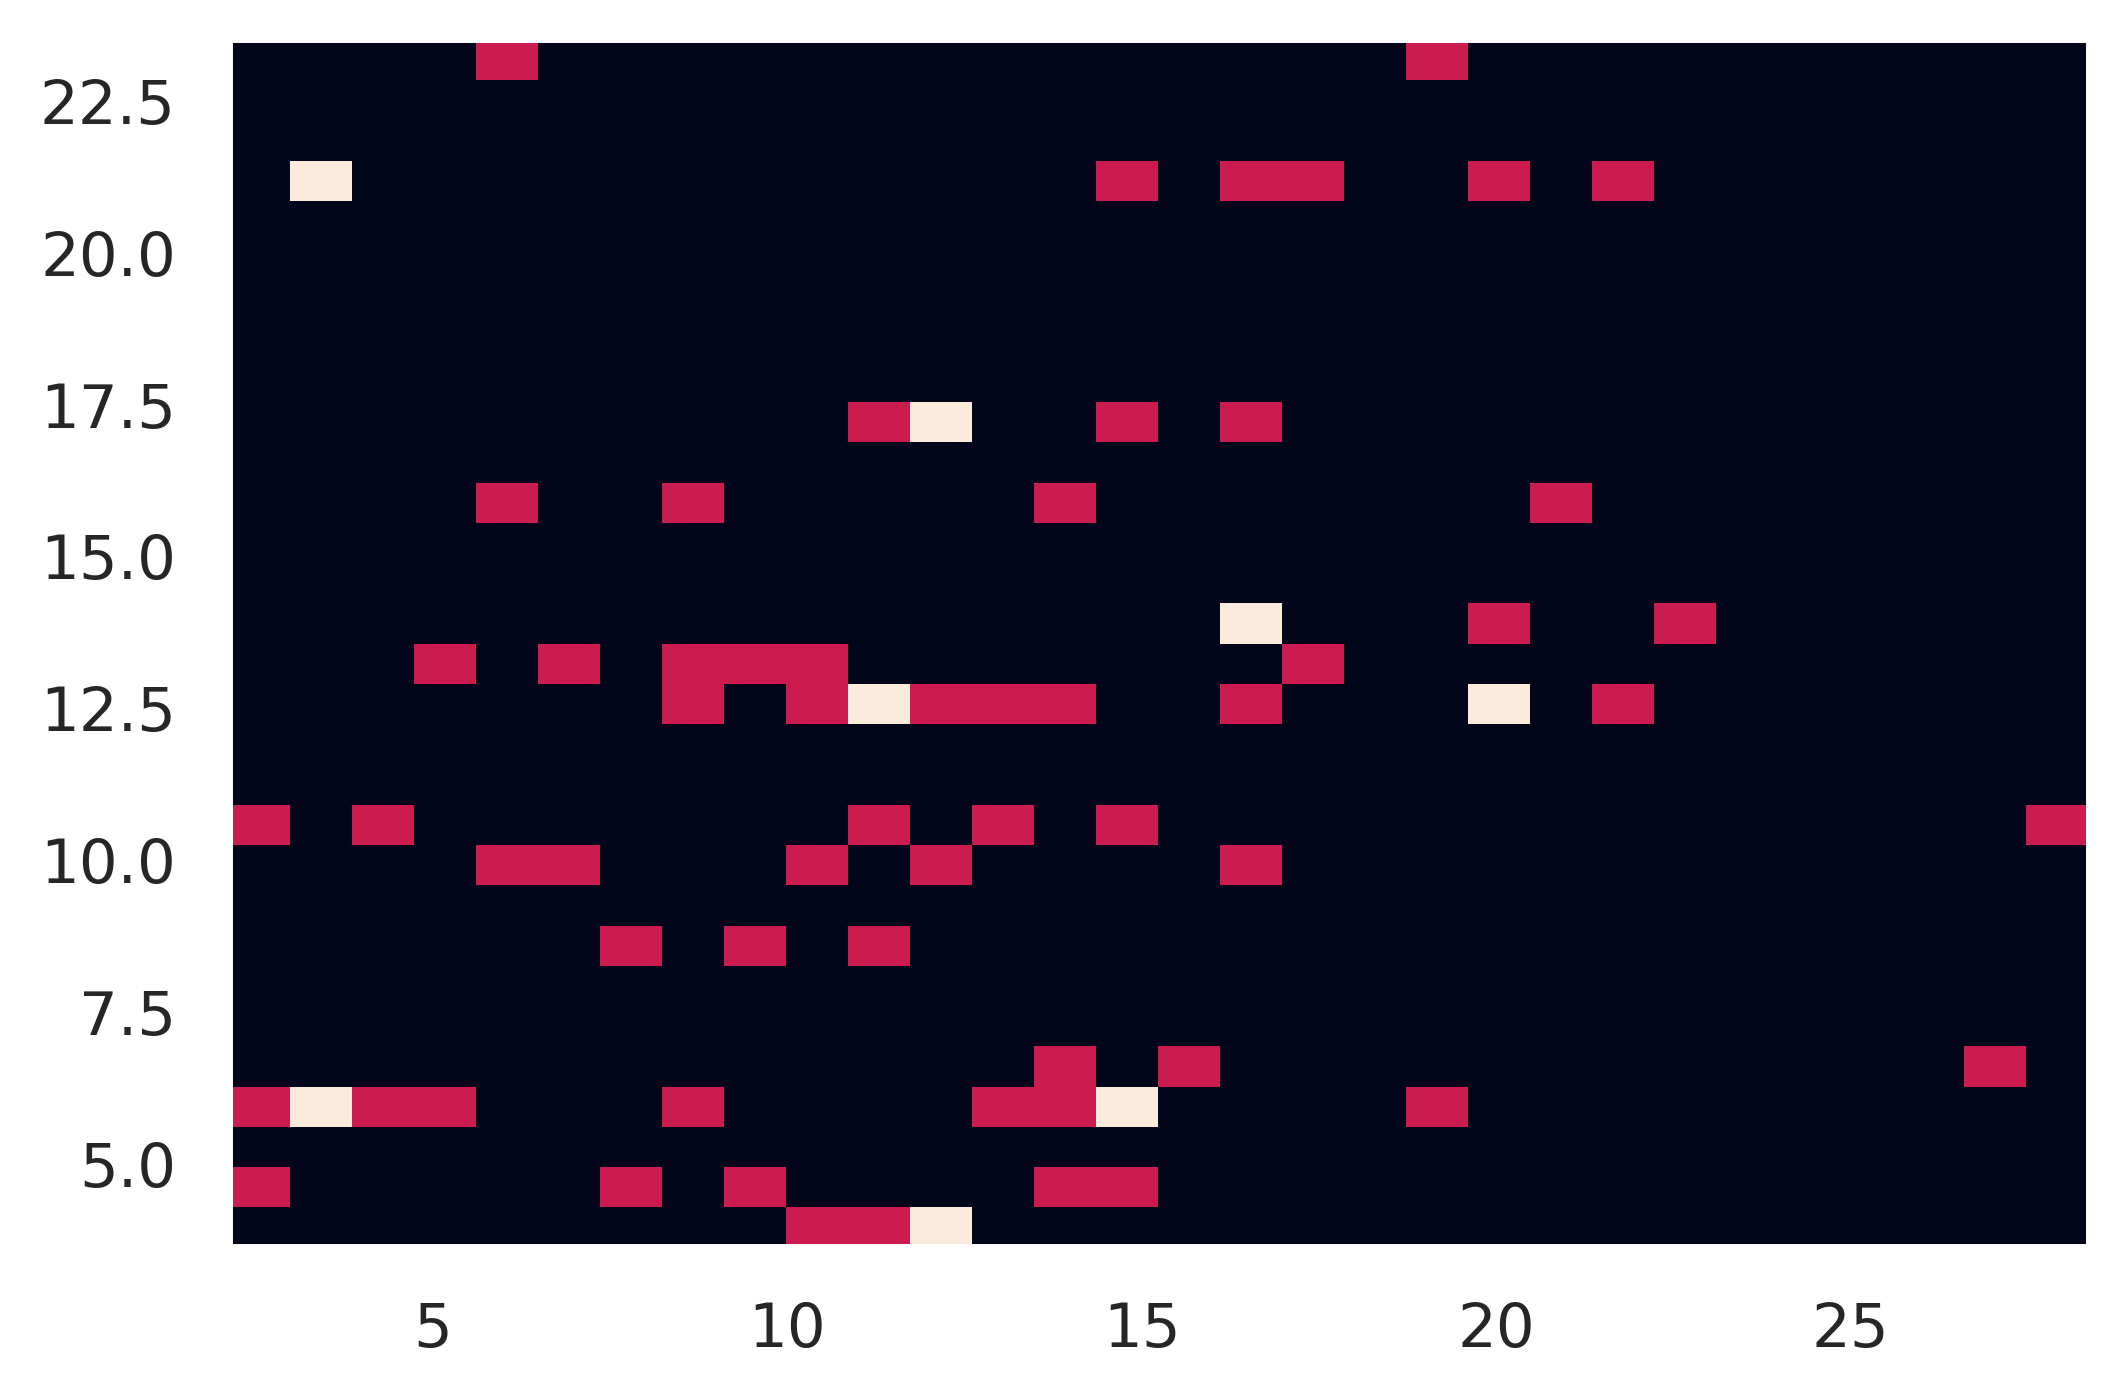

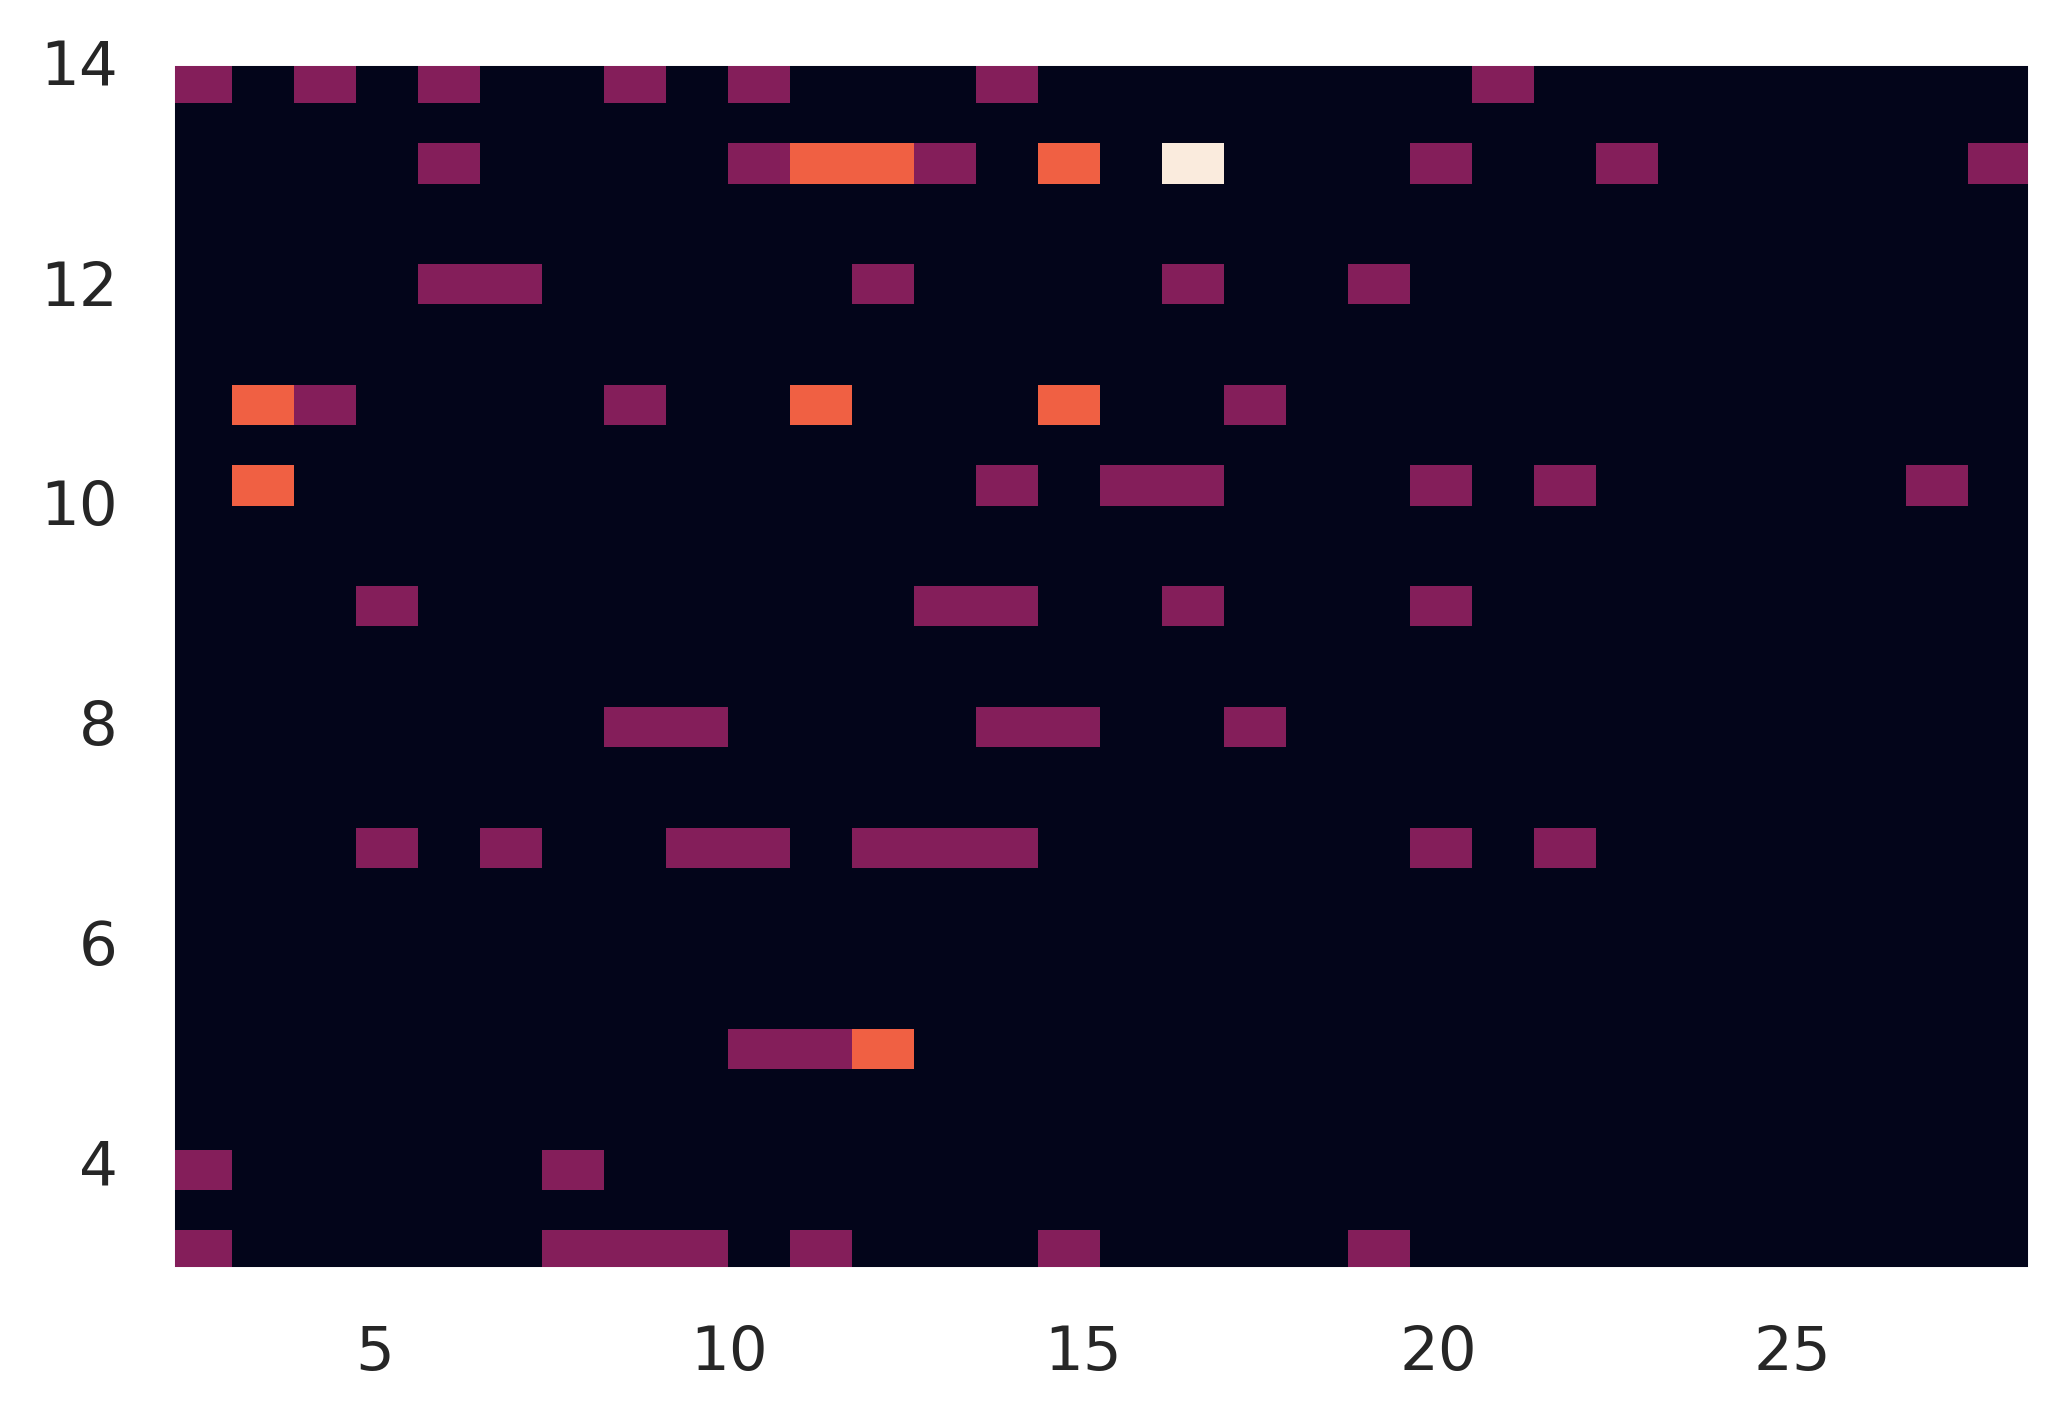

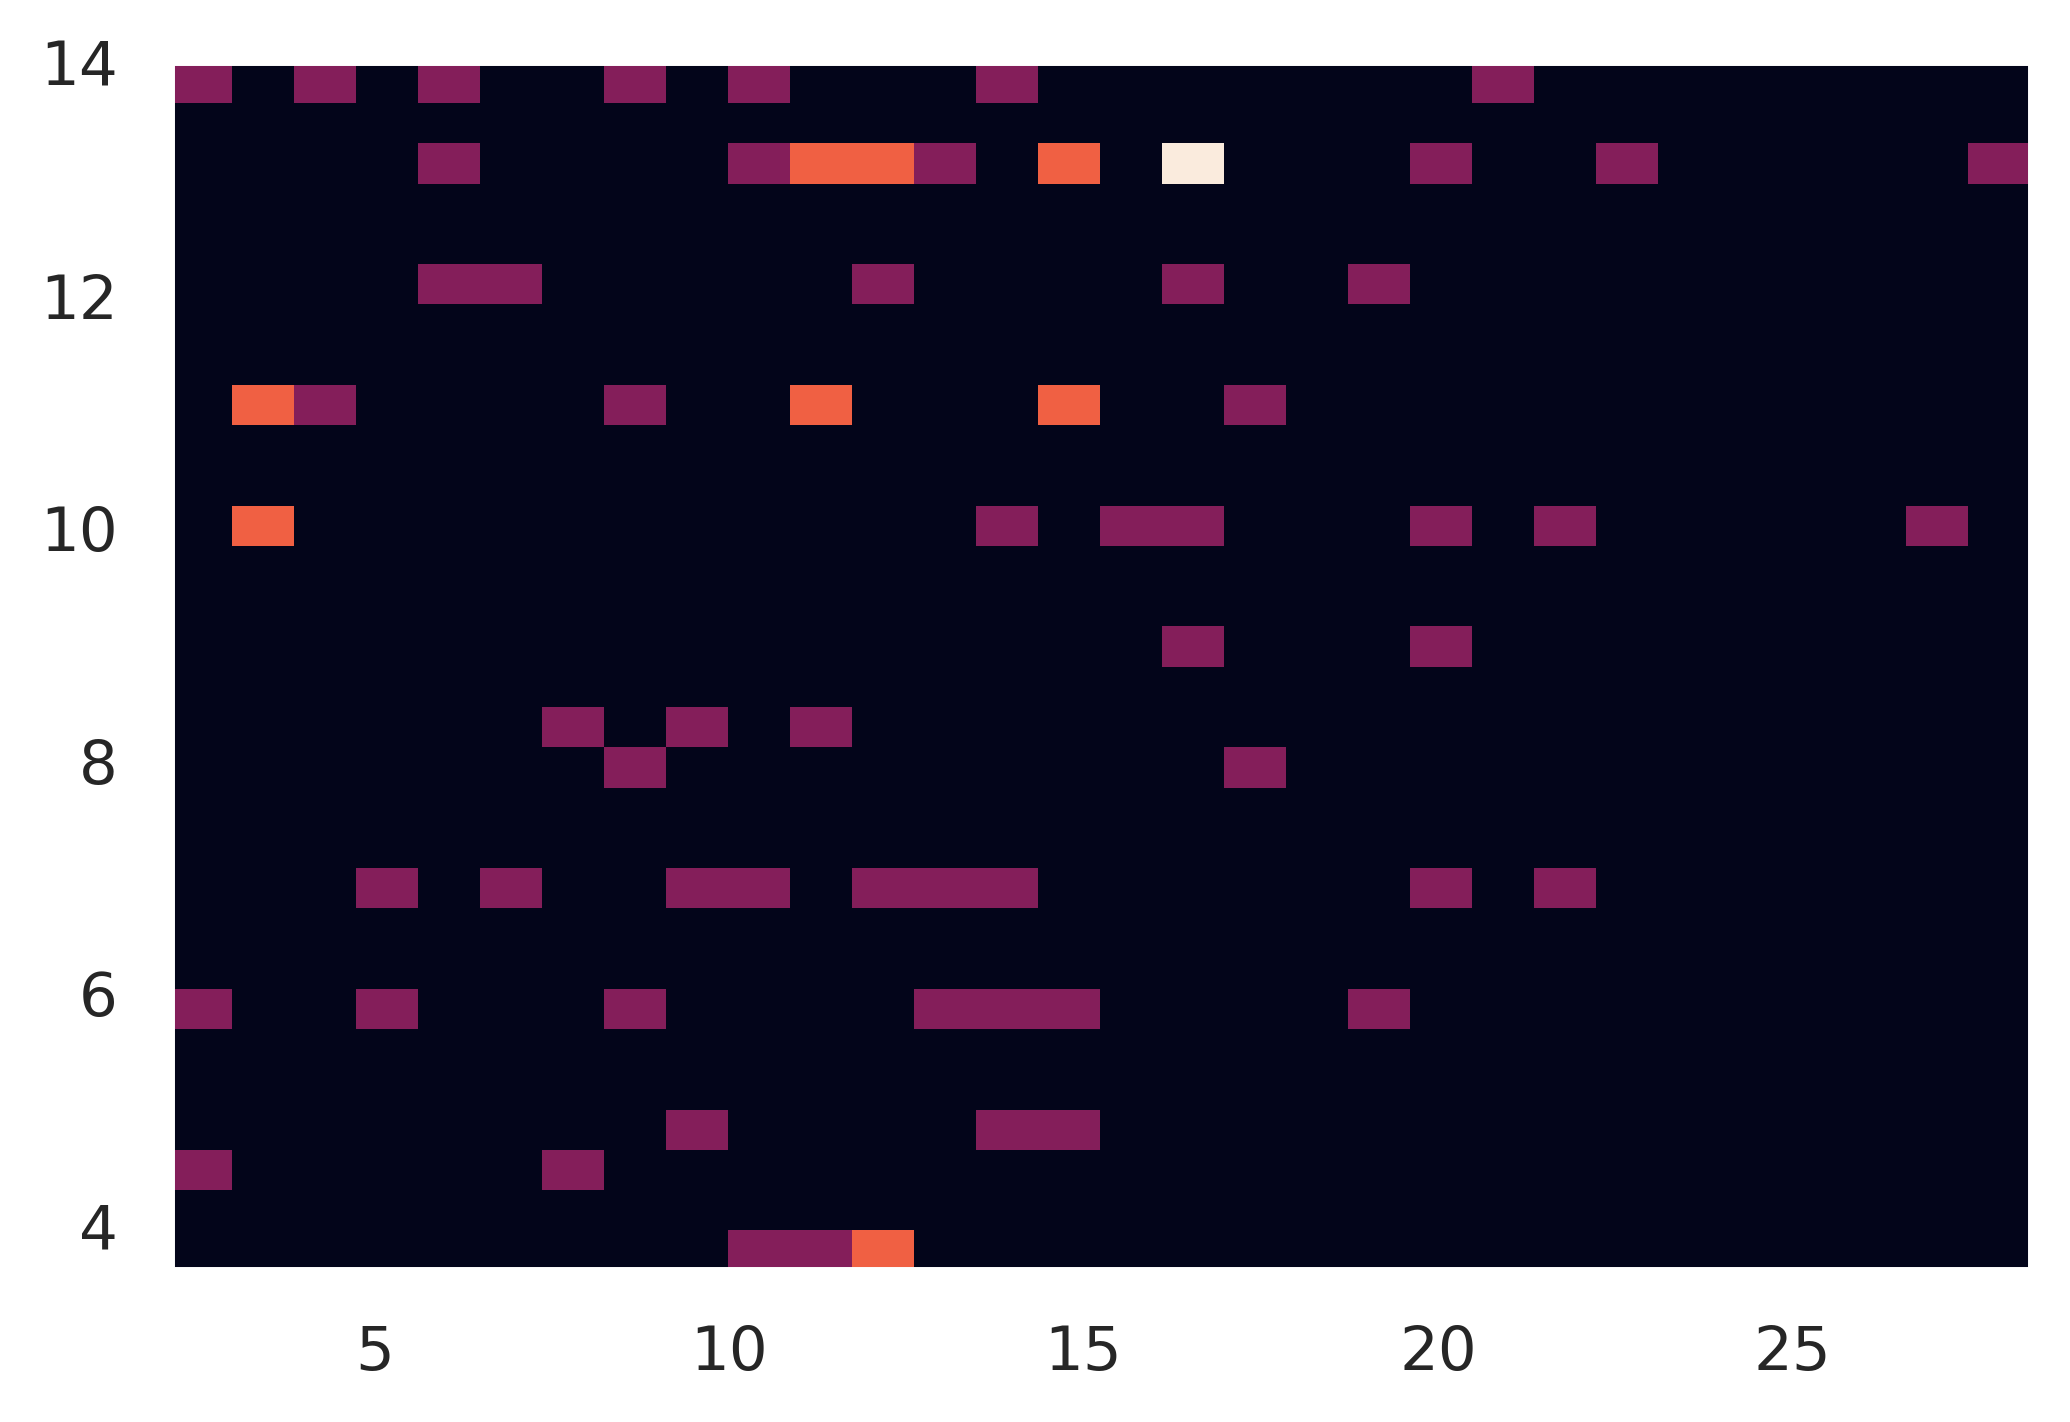

In [ ]:
x = gedi_dropna['GEDI']
y1 = gedi_dropna['Backscatter']
y2 = gedi_dropna['InSAR']
y3 = gedi_dropna['Fusion']

#call hue --> all are the same hue
#then try changing palette
#or try changing default seaborn color palette prior to graphing

#calculate metrics

#count for histogram
index = gedi_dropna.index
number_of_rows = len(index)

#R2 and RMSE for each comparison
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
statsR2_1 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y1)
rmse_1 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
statsR2_2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y2)
rmse_2 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y3)
statsR2_3 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y3)
rmse_3 = math.sqrt(mse)

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y1, bins=30)
counts_max1 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y2, bins=30)
counts_max2 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y3, bins=30)
counts_max3 = counts.max()

counts_max_next = 0
counts_max_last = 0

if counts_max1 > counts_max2:
  counts_max_next = counts_max1

else:
  counts_max_next = counts_max2

if counts_max_next > counts_max3:
  counts_max_last = count_max_next

else:
  counts_max_last = counts_max3

print(counts_max1)
print(counts_max2)
print(counts_max3)

print(counts_max_next)
print(counts_max_last)

print(counts_max_last, rmse_1, rmse_2, rmse_3, statsR2_1, statsR2_2, statsR2_3)
print(number_of_rows)

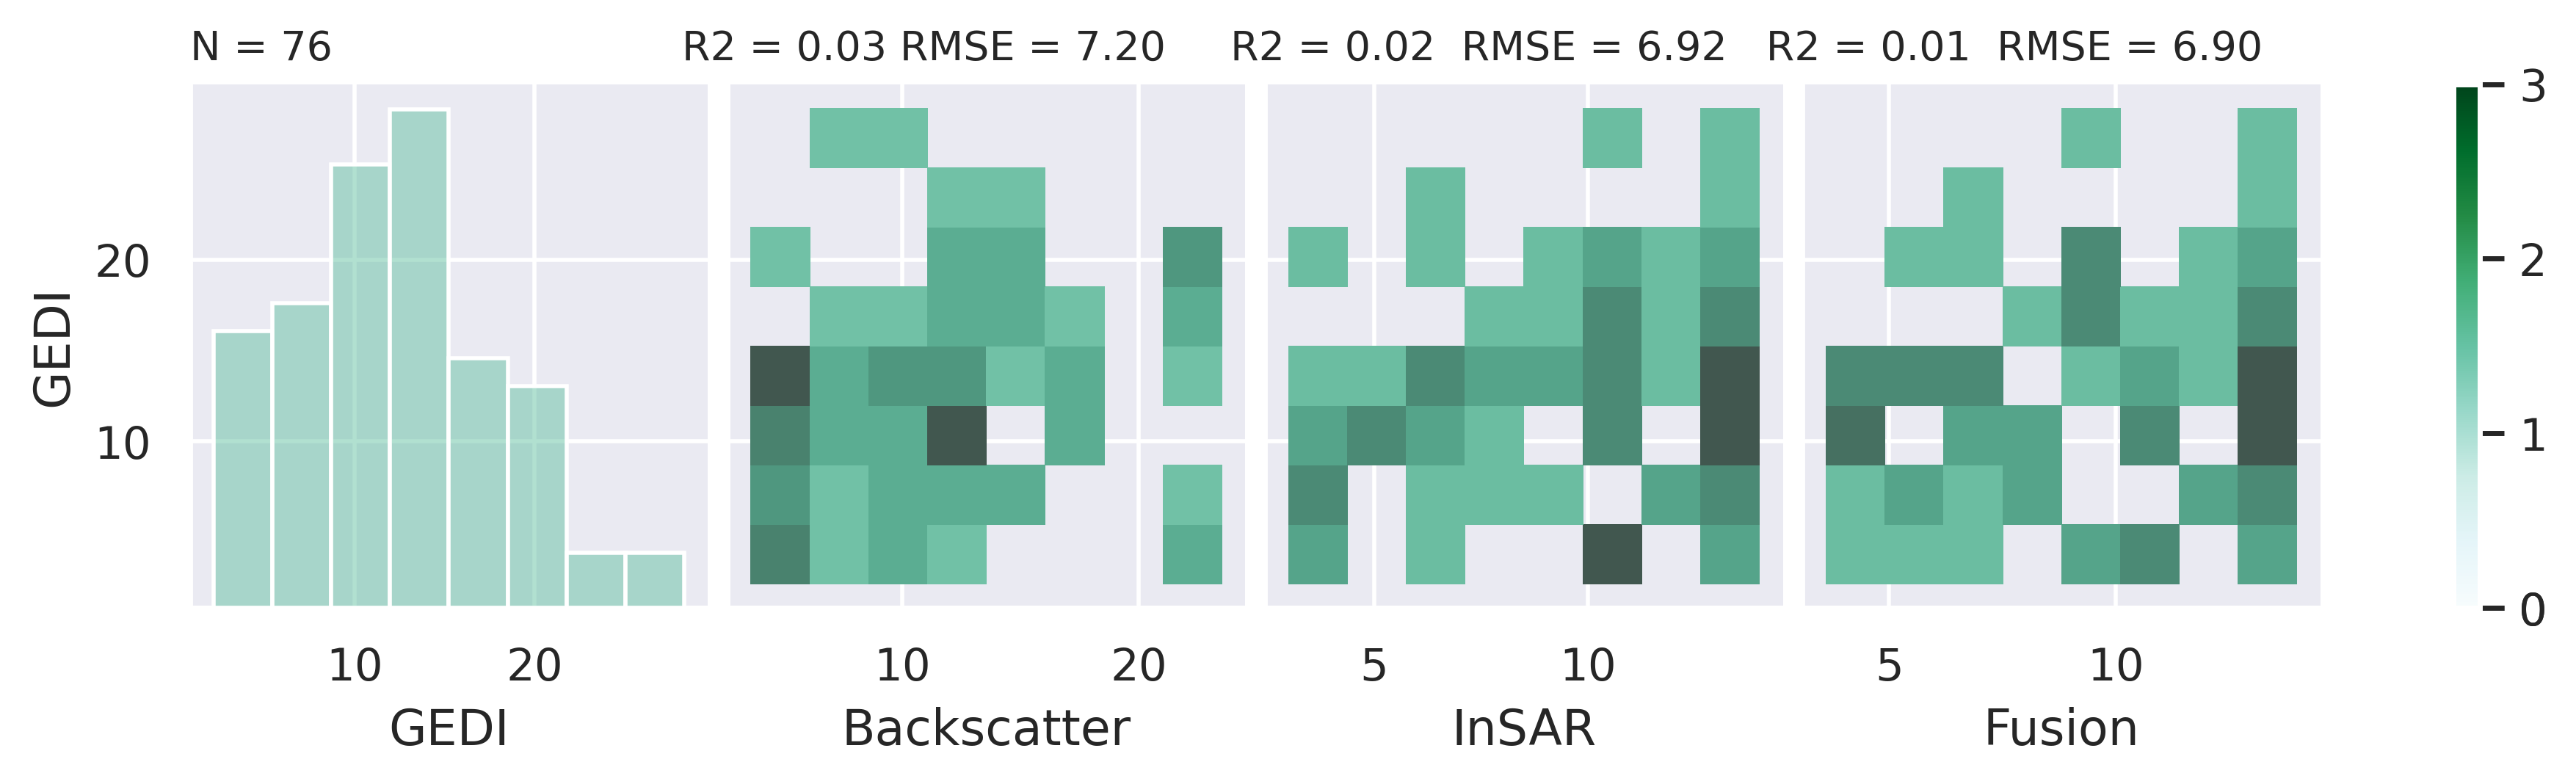

In [ ]:
title = "N = " + f"{number_of_rows:.0f}" + "                           R2 = " + f"{statsR2_1:.2f}" + " RMSE = " f"{rmse_1:.2f}"+ "     R2 = " + f"{statsR2_2:.2f}" + "  RMSE = " f"{rmse_2:.2f}"+ "   R2 = " + f"{statsR2_3:.2f}" + "  RMSE = " f"{rmse_3:.2f}"

norm = plt.Normalize(0, counts_max_last)
sm = plt.cm.ScalarMappable(cmap="BuGn", norm=norm)
sm.set_array([])

ax = sns.pairplot(
    gedi_dropna, kind="hist",
    hue="H",
    palette="BuGn",
    x_vars=["GEDI", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GEDI"],
)

cbar = plt.colorbar(sm, ax=ax.axes)

ax._legend.remove()

m0=int(0)                                 # colorbar min value
m4=int(counts_max_last)                   # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)                # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)                # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)                # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

plt.title(title, loc='left', fontsize=10)
plt.show()

##GLAD Comparison Data Prep

In [ ]:
#xglad_b is the GLAD for the backscatter comparison
#yglad_b is the corresponding backscatter
bs_fus = "backscatter_v17_extract_fus.tif"
bs_o = gdal.Open(bs_fus)
bs_array = bs_o.ReadAsArray()

insar_forglad = "insar_2009_6ha_extractv2.tif"
insar_o = gdal.Open(insar_forglad)
insar_array = insar_o.ReadAsArray()

GLAD = "GLAD_2019_extractv2.tif"
glad_o = gdal.Open(GLAD)
glad_array = glad_o.ReadAsArray()

fusion = "Fusion_v3.tif"
f_FSH = gdal.Open(fusion)
fus = f_FSH.ReadAsArray()

#print(bs_array.shape)
#print(insar_array.shape)
#print(glad_array.shape)
#print(fus.shape)

#ravel all
x_glad = np.array(glad_array).ravel()
y_bs = np.array(bs_array).ravel()
y_insar = np.array(insar_array).ravel()
y_fus = np.array(fus).ravel()

#pandas dataframe and set column name
glad_df = pd.DataFrame(x_glad, columns = ['GLAD'])
bs_df = pd.DataFrame(y_bs, columns = ['Backscatter'])
insar_df = pd.DataFrame(y_insar, columns=['InSAR'])
fus_df = pd.DataFrame(y_fus, columns=['Fusion'])

#print(lidar_df)
#print(bs_df)
#print(insar_df)
#print(fus_df)

#concatenate into one pandas dataframe
data_glad = pd.concat([glad_df, bs_df, insar_df, fus_df], axis=1)
print(data_glad)

#set nan values
glad_nan2 = np.where(data_glad<0, np.NaN, data_glad)
glad_nan = np.where(glad_nan2>254, np.nan, glad_nan2)

#pandas df again
glad_nan_df = pd.DataFrame(glad_nan, columns=['GLAD', 'Backscatter', 'InSAR', 'Fusion'])

#drop nan values
glad_dropna = glad_nan_df.dropna()
glad_dropna = glad_dropna.assign(H='hue')
print(glad_dropna.head())

        GLAD   Backscatter  InSAR        Fusion
0       -128 -3.402823e+38  65535 -3.402823e+38
1       -128 -3.402823e+38  65535 -3.402823e+38
2       -128 -3.402823e+38  65535 -3.402823e+38
3       -128 -3.402823e+38  65535 -3.402823e+38
4       -128 -3.402823e+38  65535 -3.402823e+38
...      ...           ...    ...           ...
117985  -128           NaN  65535 -3.402823e+38
117986  -128           NaN  65535 -3.402823e+38
117987  -128           NaN  65535 -3.402823e+38
117988  -128           NaN  65535 -3.402823e+38
117989  -128           NaN  65535 -3.402823e+38

[117990 rows x 4 columns]
     GLAD  Backscatter  InSAR  Fusion    H
272  14.0    21.150444   14.0    14.0  hue
274  21.0    21.787706   13.0    13.0  hue
275  22.0    16.130852   14.0    14.0  hue
276  16.0     5.532335   13.0    13.0  hue
277  22.0    15.845119   11.0    11.0  hue


## GLAD Pairplot Scatter

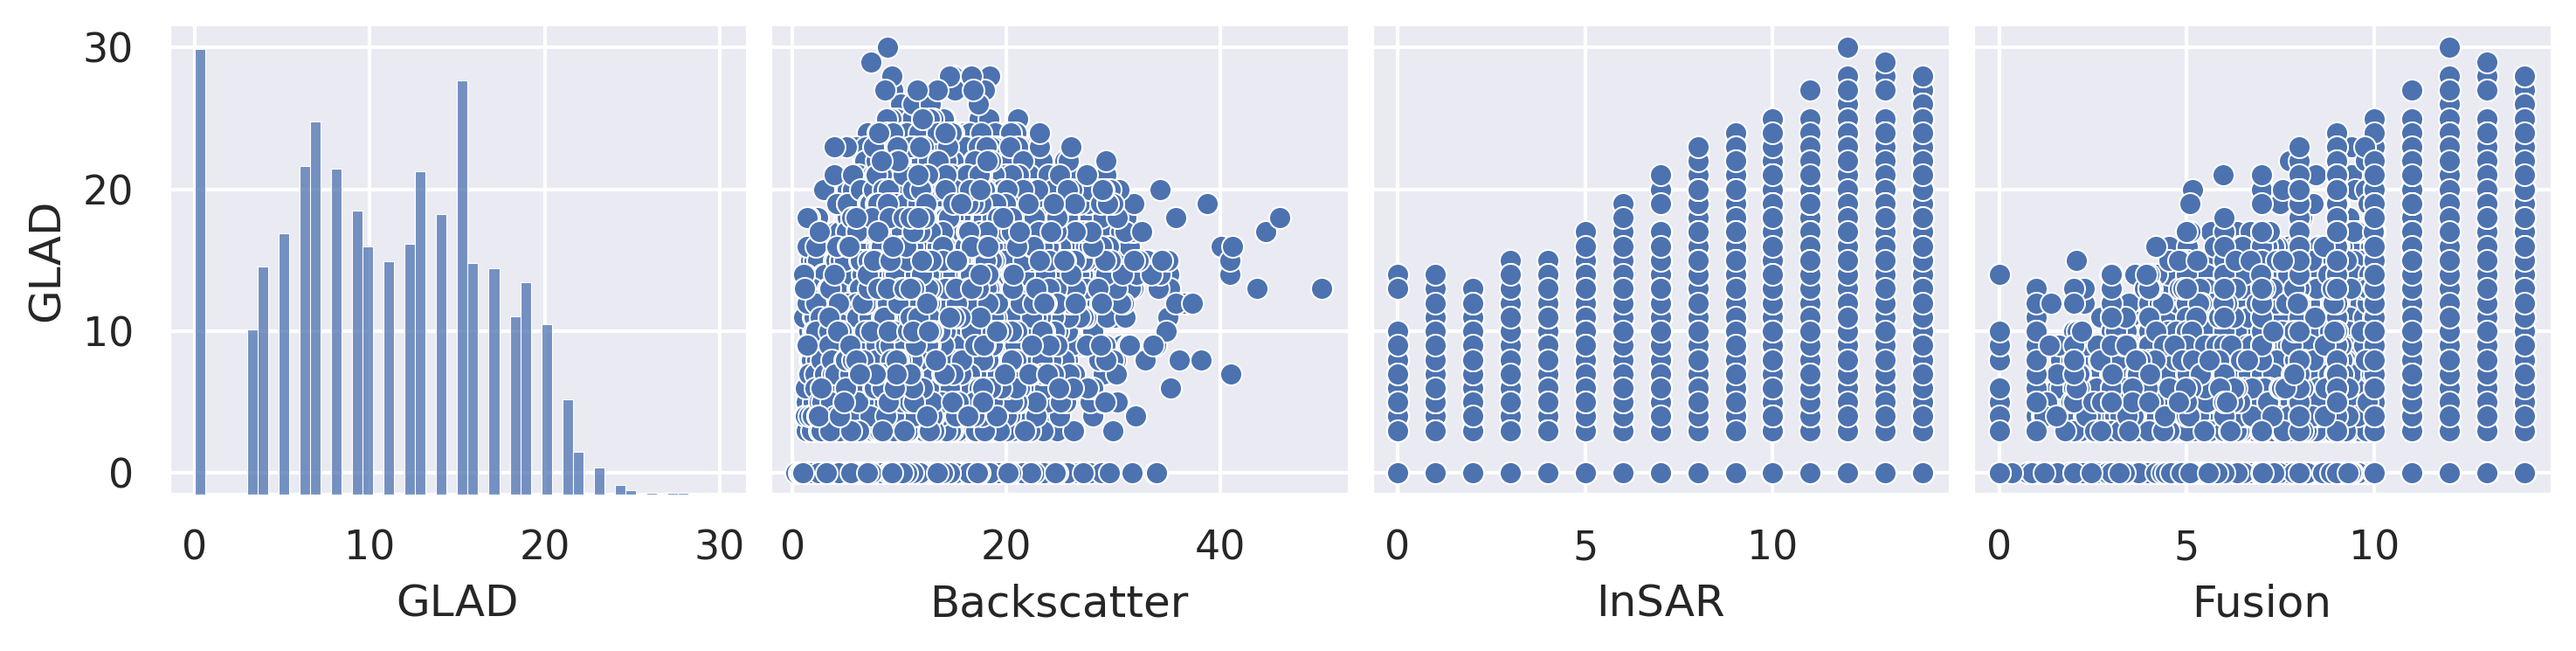

In [ ]:
sns.pairplot(
    glad_dropna,
    x_vars=["GLAD", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GLAD"],
)

## GLAD comparison, with colorbar

Go through the max counts for the three hist2ds for each set of comparisons to find the maximum max count

###metrics prep

755.0 6.206045083219358 5.330224839955855 5.322784342554997 0.12998700528391044 0.18782357254446147 0.18722340819491748


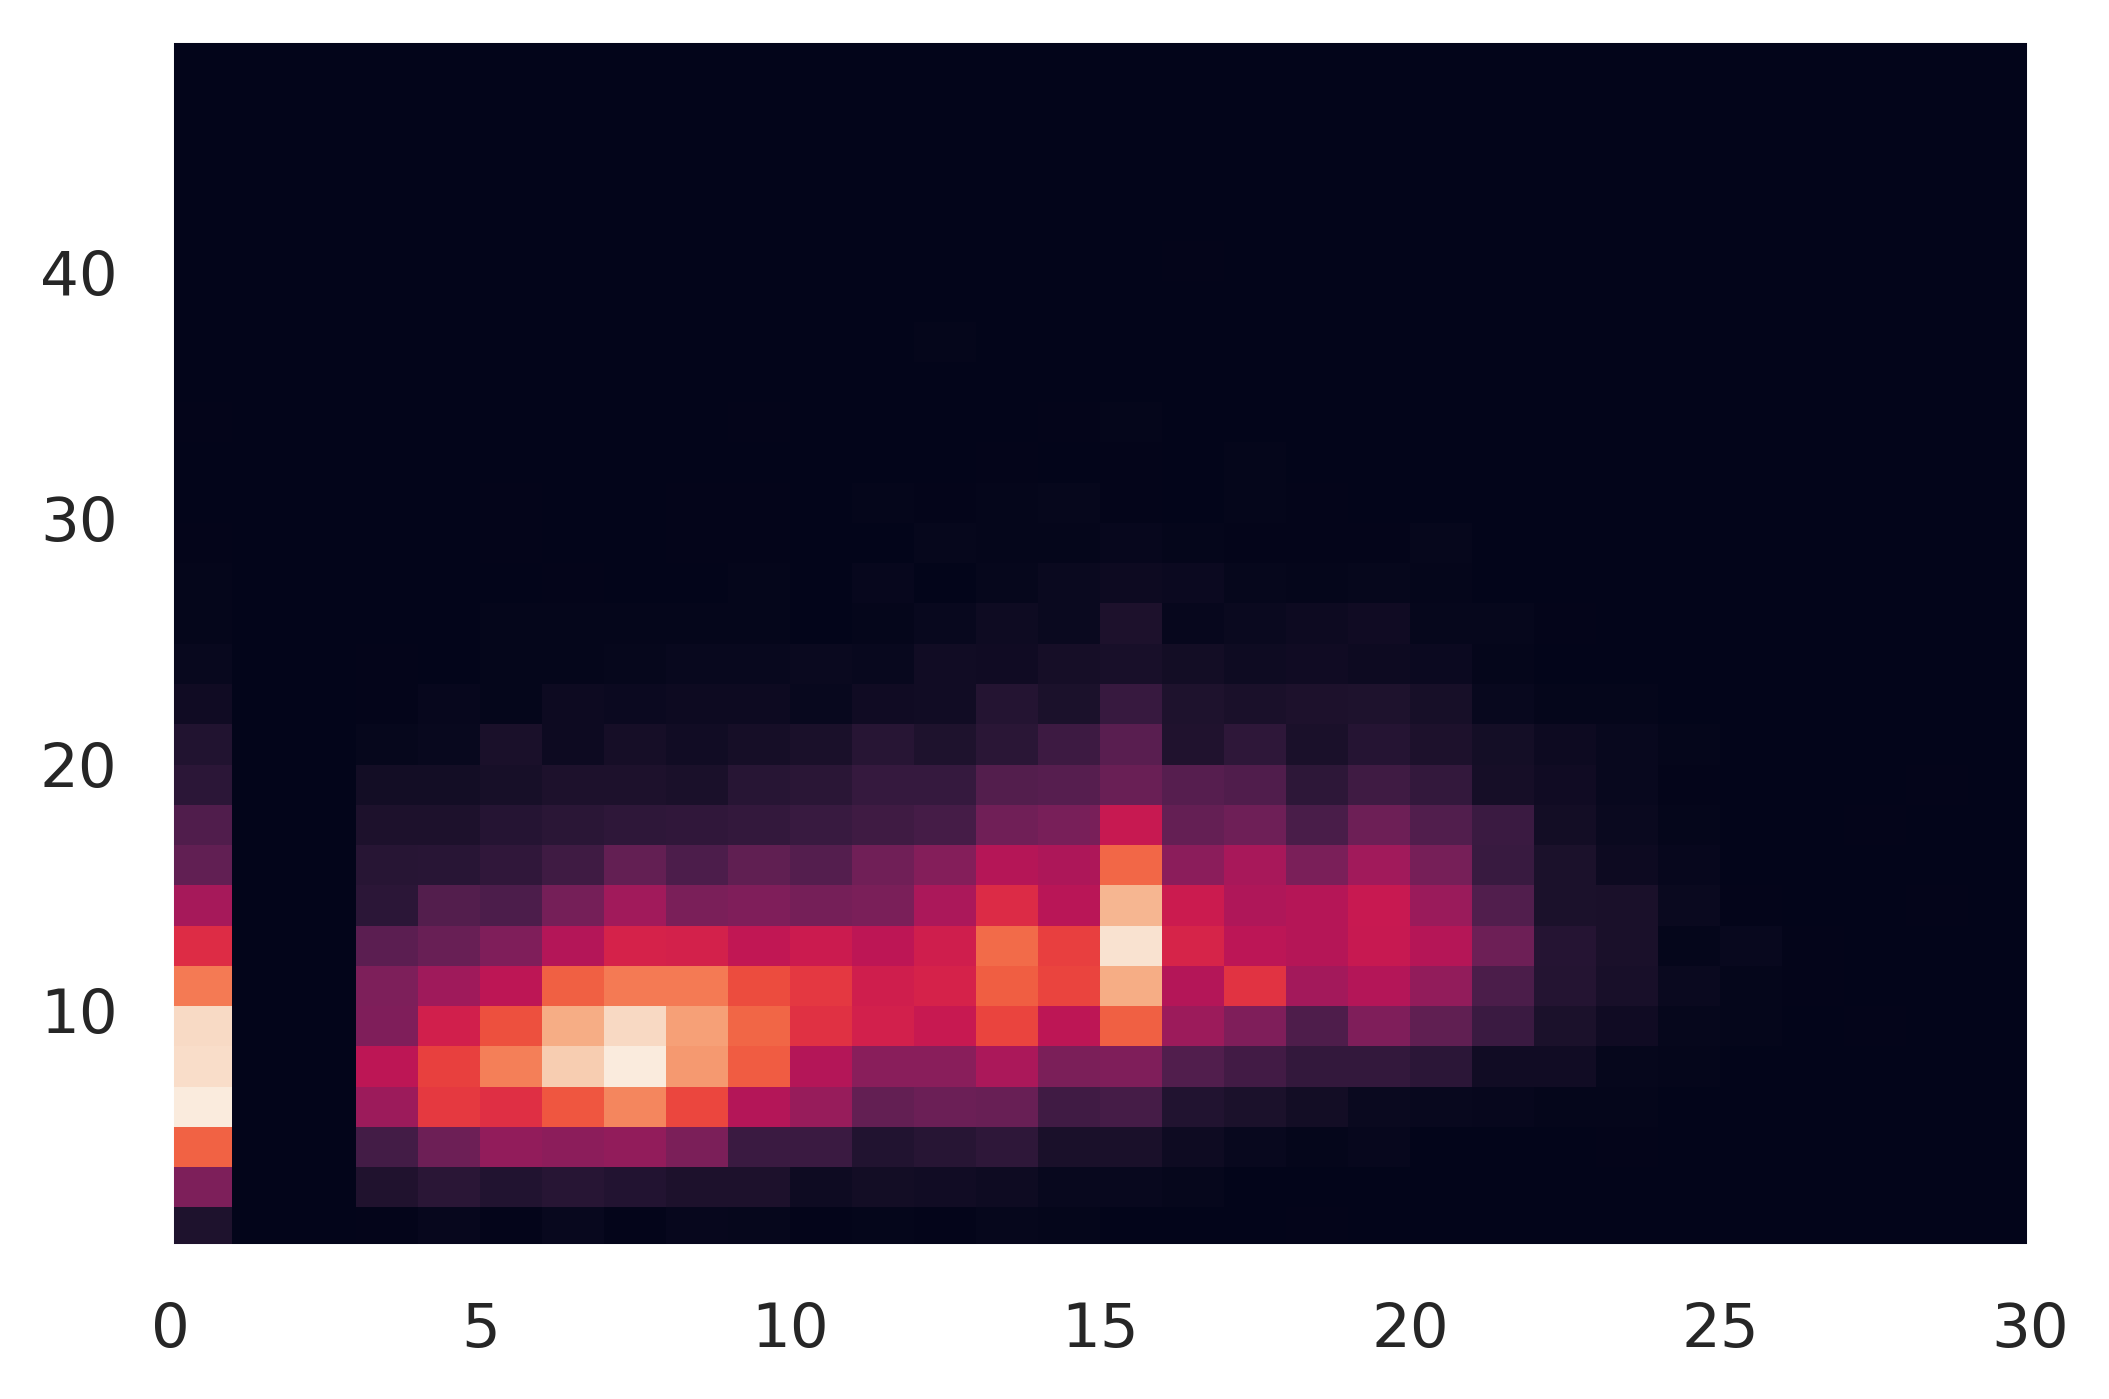

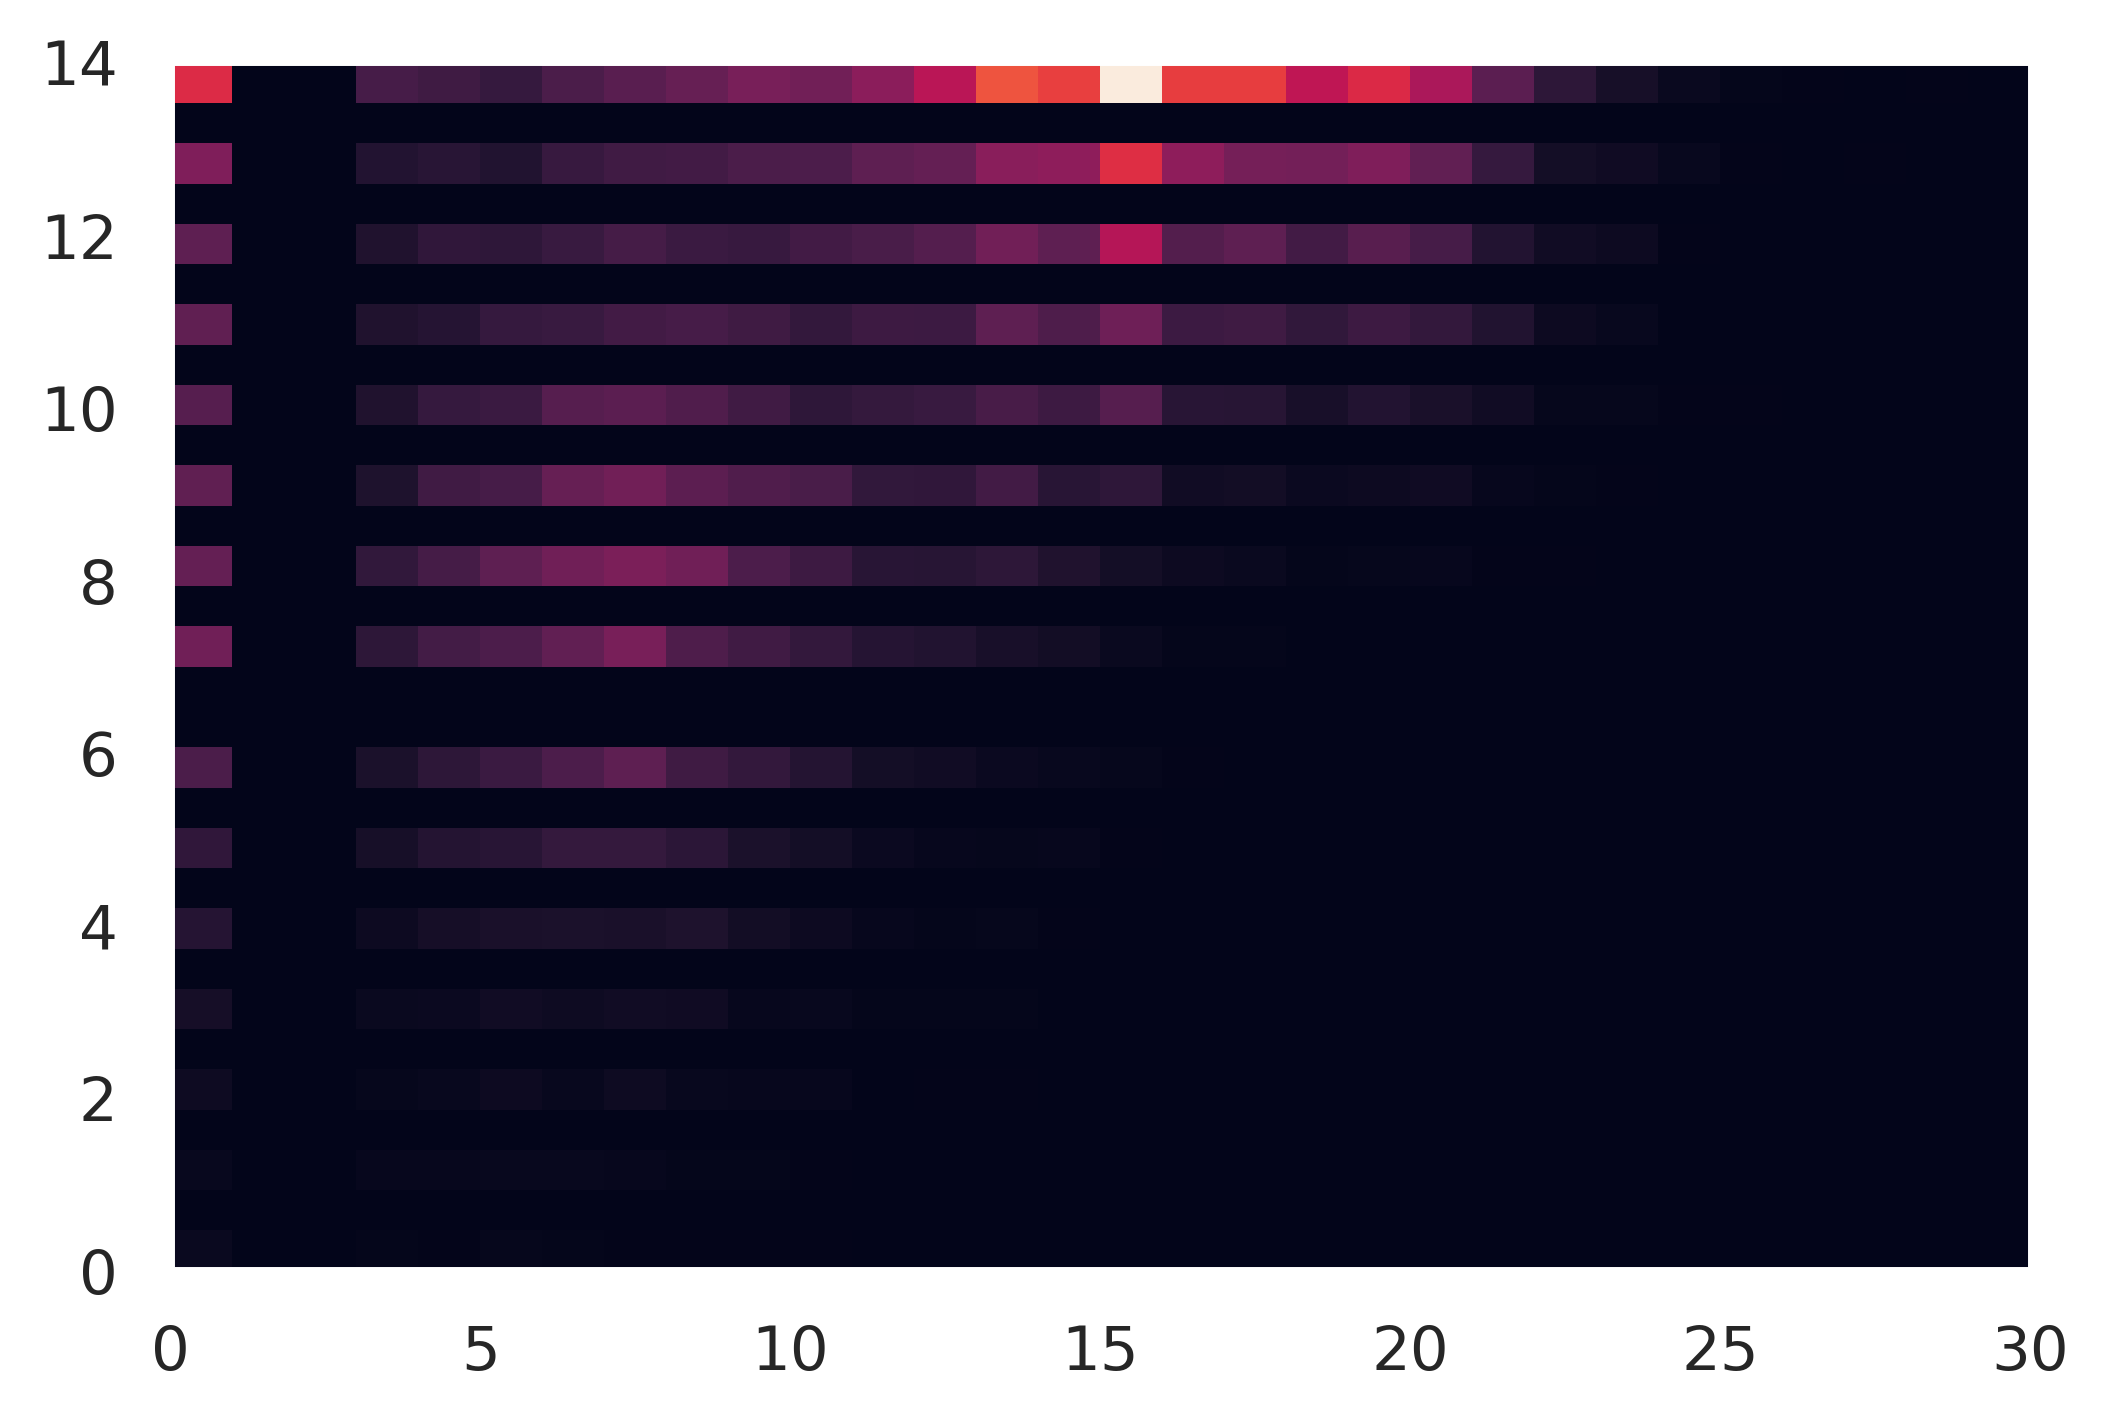

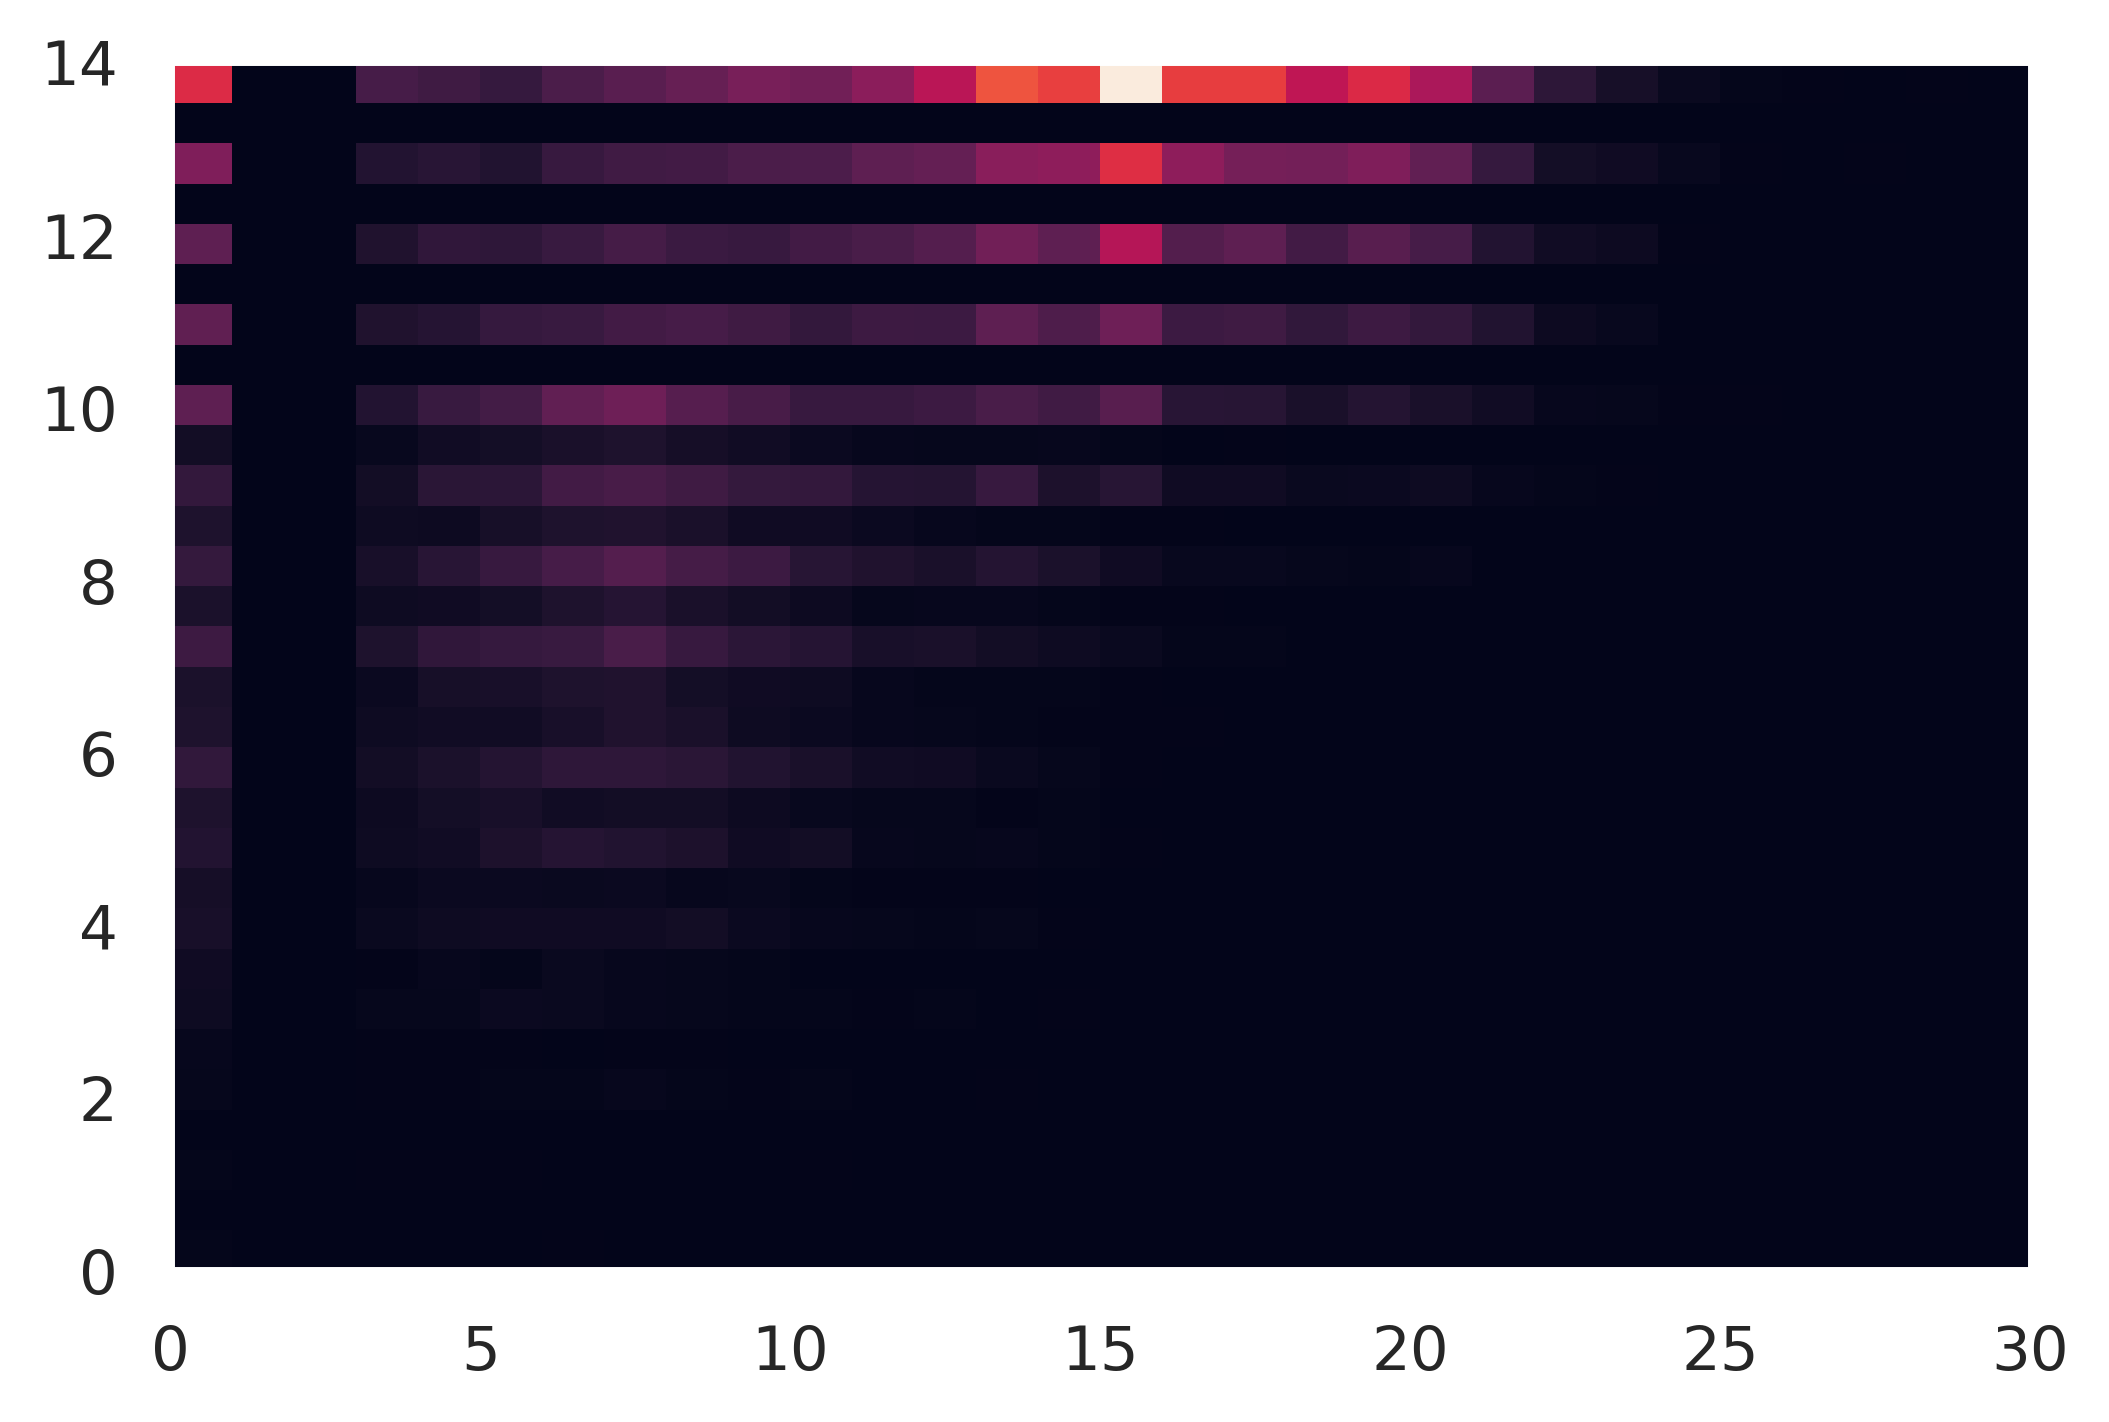

In [ ]:
x = np.array(glad_dropna['GLAD'])
y1 = np.array(glad_dropna['Backscatter'])
y2 = glad_dropna['InSAR']
y3 = glad_dropna['Fusion']

#calculate metrics

#count for histogram
index = glad_dropna.index
number_of_rows = len(index)

#R2 and RMSE for each comparison
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
statsR2_1 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y1)
rmse_1 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
statsR2_2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y2)
rmse_2 = math.sqrt(mse)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y3)
statsR2_3 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(x, y3)
rmse_3 = math.sqrt(mse)

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y1, bins=30)
counts_max1 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y2, bins=30)
counts_max2 = counts.max()

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(x, y3, bins=30)
counts_max3 = counts.max()

counts_max_next = 0
counts_max_last = 0

if counts_max1 > counts_max2:
  counts_max_next = counts_max1

else:
  counts_max_next = counts_max2

if counts_max_next > counts_max3:
  counts_max_last = count_max_next

else:
  counts_max_last = counts_max3

#print(counts_max1)
#print(counts_max2)
#print(counts_max3)

#print(counts_max_next)
#print(counts_max_last)

print(counts_max_last, rmse_1, rmse_2, rmse_3, statsR2_1, statsR2_2, statsR2_3)

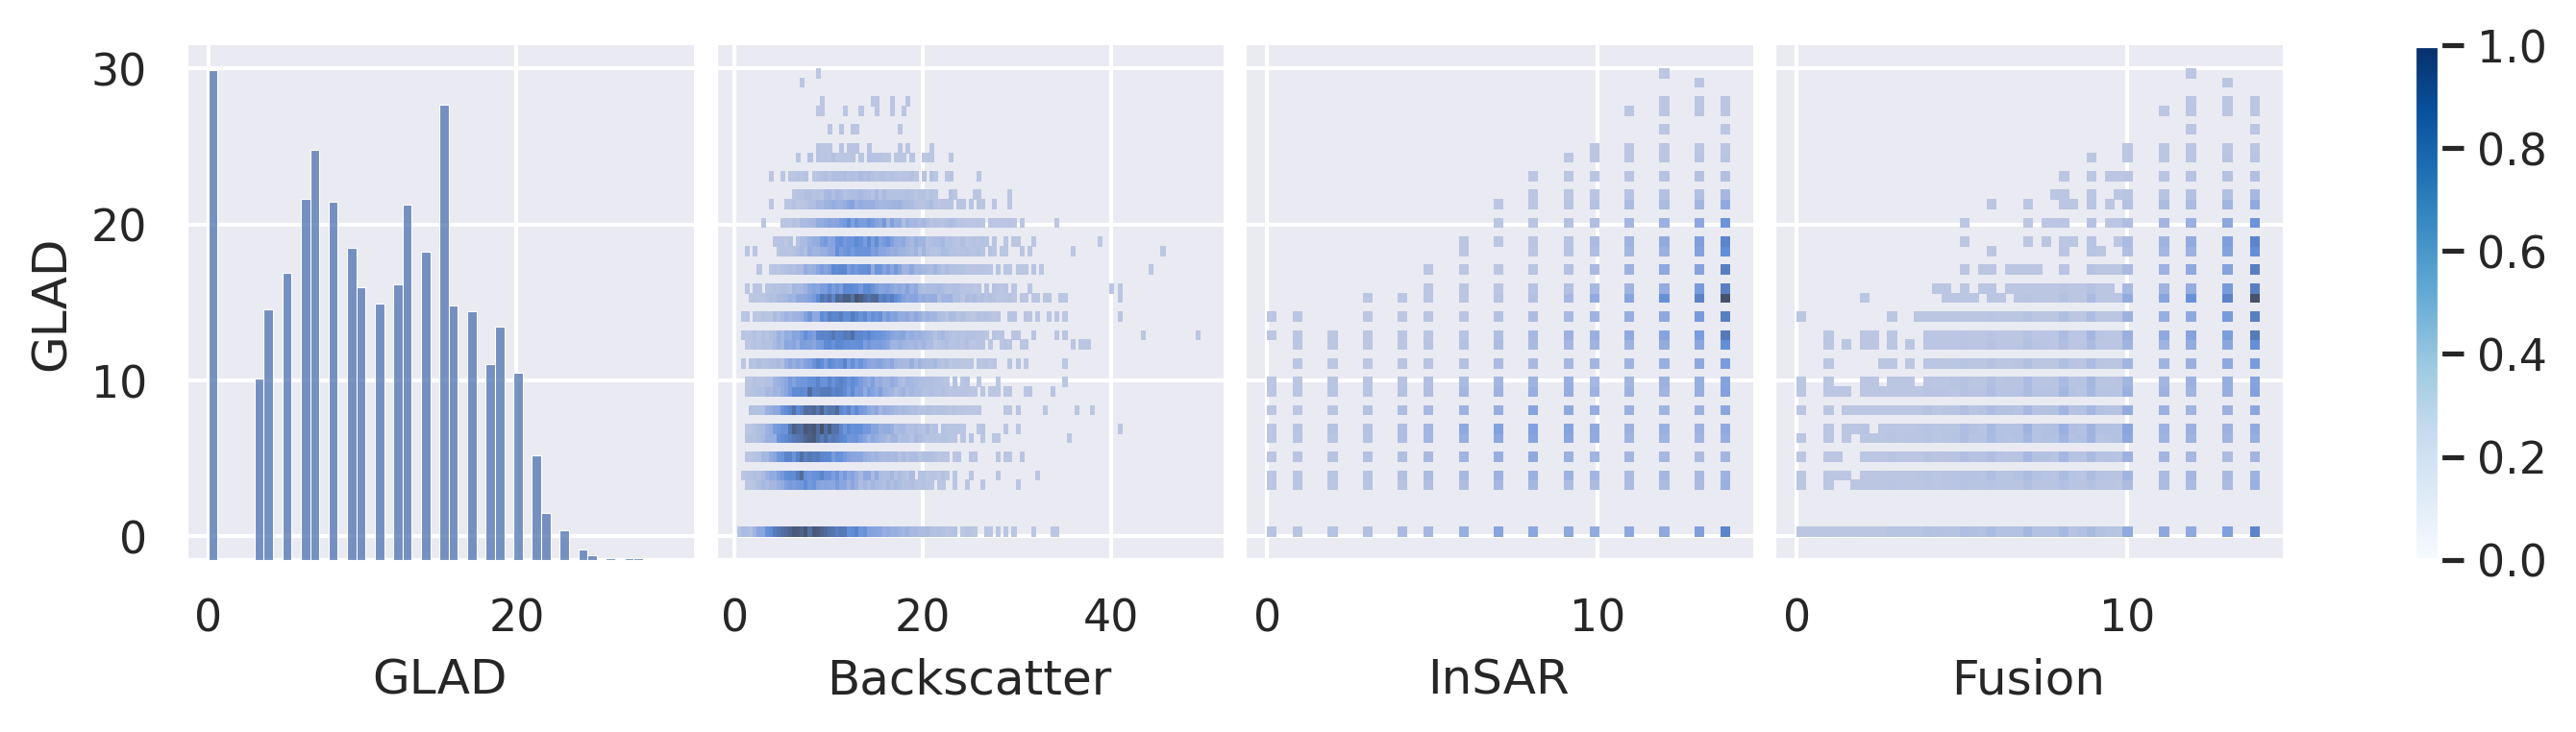

In [ ]:
# https://stackoverflow.com/questions/62070506/colorbar-next-to-seaborn-pairplot

sm = plt.cm.ScalarMappable(cmap="BuGn", norm=norm)
sm.set_array([])

ax = sns.pairplot(
    glad_dropna, kind="hist",
    hue="H",
    palette="BuGn",
    x_vars=["GLAD", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GLAD"],
)


#cbar = plt.colorbar(sm, ax=ax.axes)

m0=int(0)                                 # colorbar min value
m4=int(counts_max_last)                   # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)                # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)                # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)                # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])


cbar = plt.colorbar(sm, ax=ax.axes)
plt.show()

##GLAD comparison, with colorbar and metrics

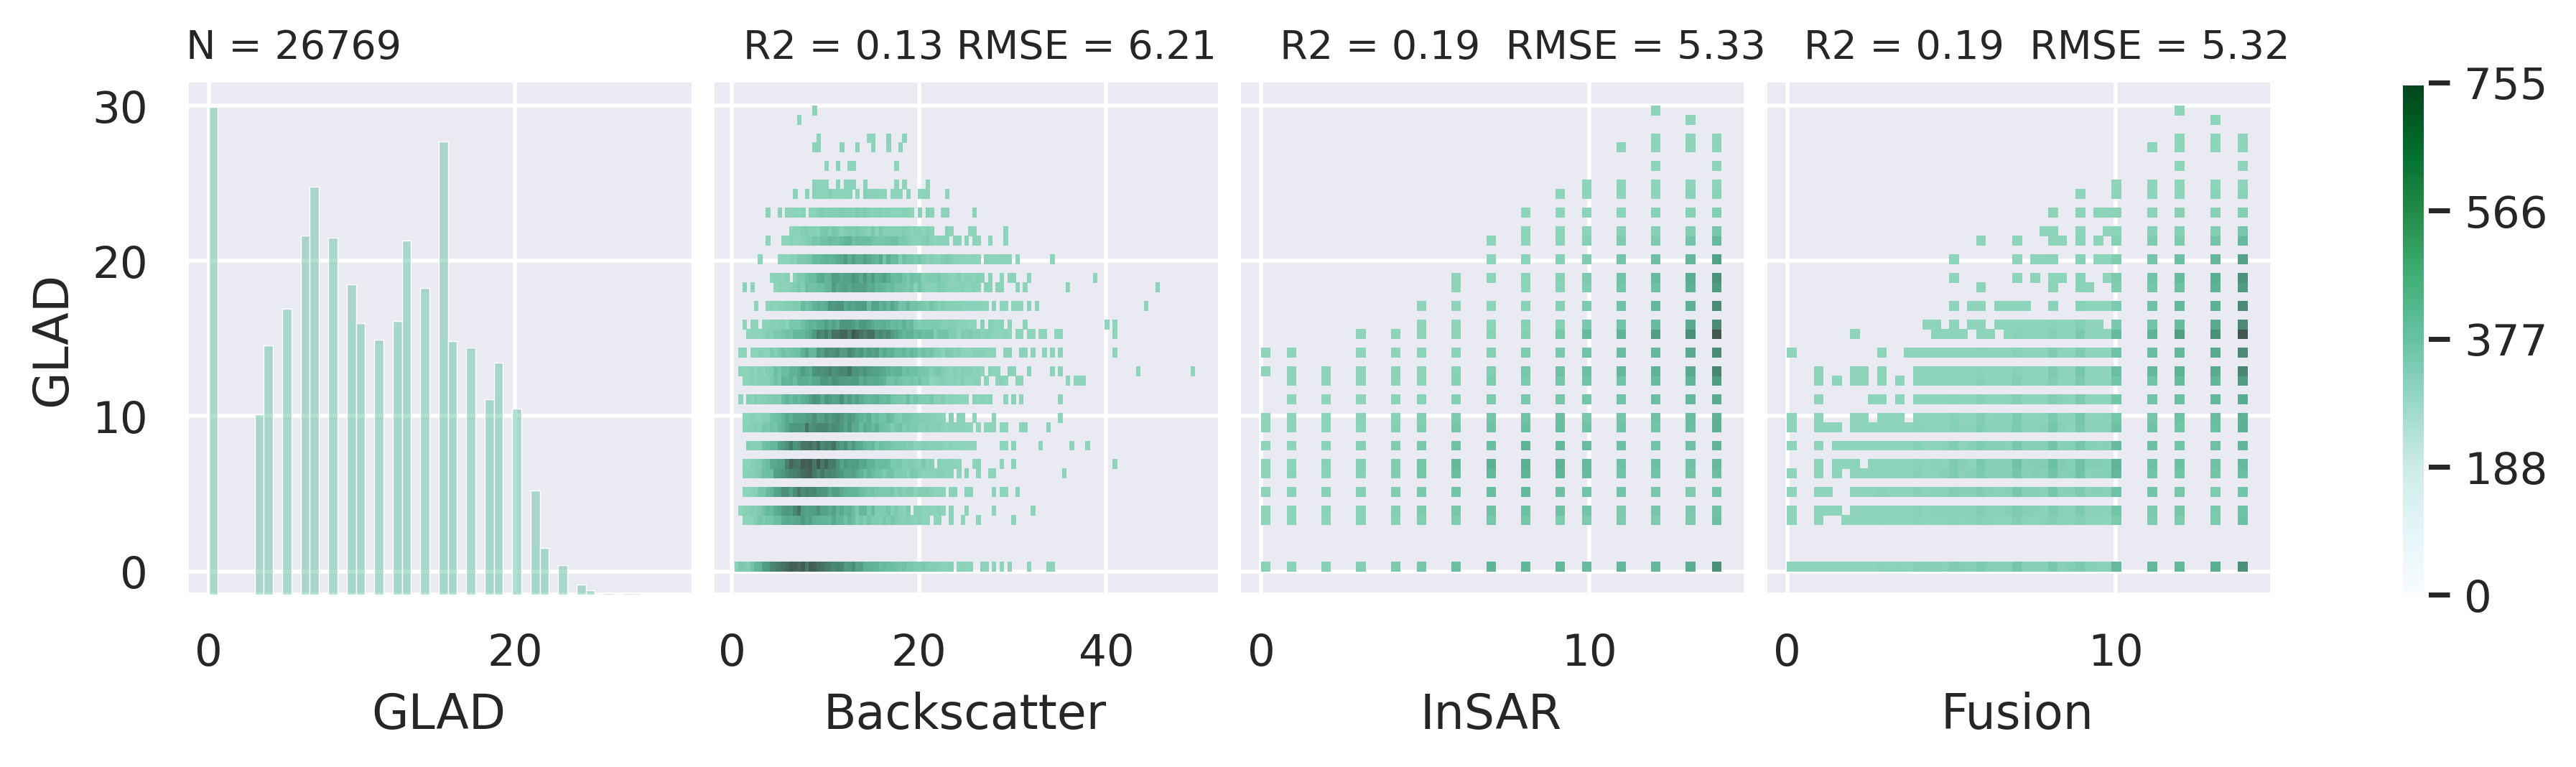

In [ ]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

title = "N = " + f"{number_of_rows:.0f}" + "                           R2 = " + f"{statsR2_1:.2f}" + " RMSE = " f"{rmse_1:.2f}"+ "     R2 = " + f"{statsR2_2:.2f}" + "  RMSE = " f"{rmse_2:.2f}"+ "   R2 = " + f"{statsR2_3:.2f}" + "  RMSE = " f"{rmse_3:.2f}"

norm = plt.Normalize(0, counts_max_last)
sm = plt.cm.ScalarMappable(cmap="BuGn", norm=norm)
sm.set_array([])

ax = sns.pairplot(
    glad_dropna, kind="hist",
    hue="H",
    palette="BuGn",
    x_vars=["GLAD", "Backscatter", "InSAR", "Fusion"],
    y_vars=["GLAD"],
)

cbar = plt.colorbar(sm, ax=ax.axes)

ax._legend.remove()

m0=int(0)                                 # colorbar min value
m4=int(counts_max_last)                   # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)                # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)                # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)                # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

plt.title(title, loc='left', fontsize=10)
plt.show()

# Putting it all tog into the final figure...


In [ ]:
#editing this one
import seaborn as sns
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(3, 1)

sns.boxplot(x="Month", y="NDVI", hue="Observations", palette="colorblind", data=vh,  orient='v' , ax=ax1)
sns.boxplot(x="Month", y="Hue", hue="Observations", palette="colorblind", data=vv,  orient='v' , ax=ax2)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol = 2)
labels = ['March', 'April','May','June']
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)
ax1.set_ylabel('NDVI')
ax2.set_ylabel('Hue')
ax2.get_legend().remove()
ax1.title.set_text(' ')
ax2.title.set_text(' ')
ax1.set_xlabel("month")
ax2.set_xlabel("month")
fig.set_size_inches(18, 5)
fig.set_dpi(300)

In [ ]:
fig, axs = plt.subplots(3, 1)
fig.set_figheight(9)
fig.set_figwidth(20)

axs[0, 0].hist2d(xnew_lid_bs, ynew_lid_bs, bins = (30, 30), cmap=plt.cm.Greys) #  testing LiDAR vs backscatter 

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_bs, ynew_lid_bs)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_bs, ynew_lid_bs)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,0].set_title(title)

axs[0, 1].hist2d(xnew_lid_in, ynew_lid_in, bins = (30, 30), cmap=plt.cm.Greys)   # testing LiDAR vs InSAR 2009

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_in, ynew_lid_in)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_in, ynew_lid_in)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,1].set_title(title)

axs[0, 2].hist2d(xnew_lid_fus, ynew_lid_fus, bins = (30, 30), cmap=plt.cm.Greys) #  testing LiDAR vs. Fusion 

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_fus, ynew_lid_fus)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_fus, ynew_lid_fus)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[0,2].set_title(title)

axs[1, 0].hist2d(xgedi_b, ygedi_b, bins = (30, 30), cmap=plt.cm.Greys) # GEDI backscatter   

slope, intercept, r_value, p_value, std_err = stats.linregress(xnew_lid_bs, ynew_lid_bs)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xnew_lid_bs, ynew_lid_bs)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,0].set_title(title)

axs[1, 1].hist2d(xgedi_i, ygedi_i, bins = (30, 30), cmap=plt.cm.Greys) #GEDI InSAR

slope, intercept, r_value, p_value, std_err = stats.linregress(xgedi_i, ygedi_i)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xgedi_i, ygedi_i)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,1].set_title(title)

axs[1, 2].hist2d(xgedi_f, ygedi_f, bins = (30, 30), cmap=plt.cm.Greys) #GEDI vs Fusion

slope, intercept, r_value, p_value, std_err = stats.linregress(xgedi_f, ygedi_f)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xgedi_f, ygedi_f)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[1,2].set_title(title)

axs[2, 0].hist2d(xglad_b, yglad_b, bins = (30, 30), cmap=plt.cm.Greys) # GLAD vs backscatter

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_b, yglad_b)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_b, yglad_b)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2,0].set_title(title)

axs[2, 1].hist2d(xglad_i, yglad_i, bins = (30, 30), cmap=plt.cm.Greys) #GLAD vs InSAR

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_i, yglad_i)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_i, yglad_i)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2, 1].set_title(title)

axs[2, 2].hist2d(xglad_f, yglad_f, bins = (30, 30), cmap=plt.cm.Greys) # GLAD vs Fusion

slope, intercept, r_value, p_value, std_err = stats.linregress(xglad_f, yglad_f)
statsR2 = r_value*r_value
mse = sklearn.metrics.mean_squared_error(xglad_f, yglad_f)
rmse = math.sqrt(mse)
title = "R2 = " + f"{statsR2:.2f}" + " RMSE = " f"{rmse:.2f}"
axs[2,2].set_title(title)

axs[2, 0].set_xlabel('LiDAR')
axs[2, 1].set_xlabel('GEDI')
axs[2, 2].set_xlabel('GLAD')
axs[2, 0].set_ylabel('Backscatter')
axs[1, 0].set_ylabel('InSAR')
axs[0, 0].set_ylabel('Fusion')

#plt.hist2d(a, b, (50, 50), cmap=plt.cm.jet)
#plt.colorbar()

plt.figure(figsize=(40, 40), dpi = 150) 
plt.show()